# Standard cGAN vs WGAN for image colorization



### Authors: 

Tonazzo Valentina: valentina.tonazzo.1@studenti.unipd.it

Zoppellari Elena: elena.zoppellari@studenti.unipd.it    

## Introduction

The coloring of black and white images is a problem that cannot be treated in a completely deterministic manner. A black and white image consists of a set of values ranging from low intensity (black, in the RGB system = 0) to high intensity (white, in the RGB system = 255), through the gray scale. Different color combinations on the color scale can correspond to a certain intensity pixel, as a colored image is the sum of three colors (in the RGB system red, green and blue). In this project, we are attempting to build a generative model capable of learning to predict the color of a grey-scale image.

## Dataset download and pre-processing

In [ ]:
import sys
import subprocess
import pkg_resources
from google.colab import drive

# Install required libraries
required = {"numpy", "torch", "torchvision", "pytorch-ignite", "tensorboardX", "tensorboard", "opendatasets", "efficientnet-pytorch","tqdm"}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
  python = sys.executable
  subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime as dt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall
from ignite.handlers import LRScheduler, ModelCheckpoint, global_step_from_engine
from ignite.contrib.handlers import ProgressBar, TensorboardLogger
import ignite.contrib.engines.common as common

import opendatasets as od
import os
from random import randint
import urllib
import zipfile
import shutil

# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
from tqdm import tqdm

The chosen dataset is the Tiny ImageNet, which is a subset of the ImageNet dataset. It contains 100,000 images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images, and 50 test images

In [ ]:
# Download and unzip dataset if needed
url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
file_name = 'tiny_imagenet.zip'
directory = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

def data_path(url, file_name, directory):
  with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
  with zipfile.ZipFile(file_name) as zf:
    zf.extractall(path="/content")

if os.path.isdir(directory) == False:
  data_path(url, file_name, directory)

# Define training and validation data paths
TRAIN_DIR = os.path.join(directory, 'train') 
VALID_DIR = os.path.join(directory, 'val')

In [ ]:
# Define device to use (CPU or GPU)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu") 

Preprocessing of the val-folder: 
Inspecting the imported dataset, it can be noticed that the training folder meets the structure needed for the customized imageloader implmented above, but the validation folder does not.

The images in the validation folder are all saved within a single folder, so they need to be reorganized into sub-folders based on their labels. 

The validation folder contains a val_annotations.txt file which comprises six tab-separated columns: filename, class label, and details of the bounding box (x,y coordinates, height, width).

In [ ]:
# The val_annotation txt file comprises 6 tab separated columns of filename, 
# class label, x and y coordinates, height, and width of bounding boxes
val_data = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Create subfolders (if not present) for validation images based on label ,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

# Save class names (for corresponding labels) as dict from words.txt file which associates labels to which object they represent 
class_to_name_dict = dict()
fp = open(os.path.join(directory, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

## Image pre-processing transformations
Each image in the dataset is represented in the RGB color space, so it has a dimension of 64 × 64 × 3 where 3 is the number of channels (red, blue, and green), which combine additively to determine the color of the image. We decided to convert the images from the RGB color space to the Lab color space in order to isolate the L channel, which represents luminance, creating a black and white copy of each colored image. Finally, both colored and grayscale images are normalized to the range of $[-1,1]$ .

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale and to LAB space before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      lab_chans = rgb2lab(img_original)
      L_chan, a_chan, b_chan = np.split(lab_chans, 3, axis=2)

      #each channel should be properly normalized in order ti give results which belong to the range [-1,1]
      img_L = L_chan / 50 - 1
      img_a = a_chan / 110
      img_b = b_chan / 110
      img_L3 = np.stack([img_L]*3, axis=-1).reshape(64, 64, 3)
      img_L3 = torch.from_numpy(img_L3.transpose((2, 0, 1))).float()
      img_lab = np.stack([img_L, img_a, img_b], axis=-1).reshape(64, 64, 3)
      img_lab = torch.from_numpy(img_lab.transpose((2,0,1))).float()

    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_L3, img_lab, target

In [ ]:
# Training
train_transforms = T.Compose([T.Resize(64), T.CenterCrop(64), T.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('/content/tiny-imagenet-200/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=128, shuffle=True)

# Validation 
val_transforms = T.Compose([T.Resize(64), T.CenterCrop(64)])
val_imagefolder = GrayscaleImageFolder('/content/tiny-imagenet-200/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=128, shuffle=True)

In [ ]:
# Functions to display single or a batch of sample images
def imshow(img):
  ''' it allows to plot with matplotlib imshow an image tensor. Parameters:
  img: image as torch tensor in RGB color space
  '''
  npimg = img.detach().numpy()
  plt.imshow(np.transpose(npimg, (2, 1, 0)))
  plt.show()

def unnormalize(tensor_lab, type):
  ''' it reconstructs normalized data. Parameters:
  tensor_lab: image as torch tensor in LAB space, normalized
  type: if "L" it reconstructs a grayscale image, else a colored image
  '''
  L_chan, a_chan, b_chan = torch.unbind(tensor_lab)
  if type == "L":
    img_L = (L_chan+1)/2 * 100
    img_a = (a_chan+1)/2 * 100
    img_b = (b_chan+1)/2 * 100

  else:
    img_L = (L_chan+1)/2 * 100
    img_a = a_chan * 110
    img_b = b_chan * 110

  return torch.as_tensor(np.transpose(np.stack([img_L, img_a, img_b], axis=-1).reshape(64, 64, 3), (2,1,0)))

def lab_to_rgb(tensor_lab):
  ''' it converts un-normalized images (torch tensor type) from LAB color space to RGB color space. Parameters:
  tensor_lab: un-normalized images (torch tensor type) in LAB space
  '''
  return torch.as_tensor(np.transpose(lab2rgb(np.asarray(torch.permute(tensor_lab,(2,1,0)).detach().numpy(), dtype=np.float32)), (2,1,0)))

def visualize(x, y, y_pred, n):
  ''' this function helps to visualize the result of the training on the test. Parameters:
  x: test set of grayscale images (normalized and in LAB space)
  y: test set of true colored images (normalized and in LAB space)
  y_pred: the predictions of the generator on the test set (normalized and in LAB space)
  n: the numer of images we want to check on the first batch (max: batch_size=128)
  '''
  for i in range(n):
    print("Grayscale image:")
    x_un = unnormalize(x[i], "L")
    x_rgb = lab_to_rgb(x_un).detach().numpy()
    x_rgb = np.transpose(x_rgb, (2, 1, 0))
    x_rgb1 = x_rgb[:,:,0] # only one channel for grayscale image
    plt.imshow(x_rgb1, cmap="gray")
    plt.show()

    print("True Value:")
    y_un = unnormalize(y[i], "lab")
    y_rgb = lab_to_rgb(y_un)
    imshow(y_rgb)
    print("Prediction:")
    y_un_pred = unnormalize(y_pred[i].detach(), "lab")
    y_rgb_pred = lab_to_rgb(y_un_pred)
    imshow(y_rgb_pred)

def backtojpeg(tensor):
  ''' it allows to convert a torch tensor image to a JPEG image. Parameters:
  tensor: image as torch tensor in RGB space
  '''
  jpeg = T.Compose([T.ToPILImage()])
  return jpeg(tensor)

## GAN model
Generative Adversarial Networks (GANs) are a type of deep learning model designed for different generative tasks. They consist of two neural networks: a generator and a discriminator network. The first one learns to generate new data samples that are similar to the training data, while the discriminator network tries to distinguish between real data samples and generated ones.

During training, the generator and discriminator play a two-player minimax game, in which the generator tries to fool the discriminator by producing more realistic data samples, while the discriminator tries to become better at identifying generated data. This competition drives both networks to improve, leading to the generation of increasingly realistic data.
   

### Generator: U-NET Autoencoder

A U-Net autoencoder was chosen as the generative neural network.
As autoncoder it consists of two parts: an encoder and a decoder. The encoder compresses the input data into a low-dimensional representation to capture the meaningful informations while the decoder reconstructs the data back to its original form. The U-Net architecture is characterized by having skip connections between the encoder and decoder, which allow the network to preserve spatial information and reduce the risk of information loss during the compression stage. 


In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 4,stride = 2,padding = 1, bias = False, padding_mode="reflect")
            if down  
            # ConvTranspose2d is applied only in upsampling
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),                      # in: 64x64x3, out: 32x32x64
            nn.LeakyReLU(0.2),                                        
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)       # in: 32x32x64, out: 16x16x128
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False)   # in: 16x16x128, out: 8x8x256
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False)   # in: 8x8x256, out: 4x4x512
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)   # in: 4x4x512, out: 2x2x512

        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()                               # in: 2x2x512, out: 1x1x512
        )

        self.up3 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)      # in: 1x1x512, out: 2x2x512
        self.up4 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False) # in: (2x2x512)x2, out: 4x4x512    
        self.up5 = Block(features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False) # in: (4x4x512)x2, out: 8x8x256
        self.up6 = Block(features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False) # in: (8x8x256)x2, out: 16x16x128
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)     # in: (16x16x128)x2, out: 32x32x64

        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),      # in: (32x32x64)x2, out: 64x64x3
            # the input images are normalized in the range [-1,1], therefore the output of the generator should be in the same range.
            # to achieve it, Tanh is chosen as activation function.
            nn.Tanh(),                                                                              
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        bottleneck = self.bottleneck(d5)
        up3 = self.up3(bottleneck)
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))        


In [ ]:
Gmodel = Generator()
Gmodel.cuda()
print(Gmodel)

Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, pa

In [ ]:
def Test_gen():
  x = torch.randn((1,3,64,64))   #per 3 channels= ((1,3,256,256))
  model = Generator(in_channels=3, features=64)
  preds = model(x)
  print(preds.shape)

In [ ]:
Test_gen()

torch.Size([1, 3, 64, 64])


### Discriminator: PatchGAN
A Patch-GAN has been chosen as the discriminative neural network. 
A PatchGAN is a type of convolutional neural network (CNN) architecture which operates by classifying image patches as real or fake, rather than the entire image, so the final output of the PatchGAN is a map indicating the probabilities that each patch in the image is real or not. One advantage of this kind of architecture is that it is less prone to being fooled by small, local artifacts in the generated images, as it focuses on individual image patches rather than the entire image.

* conversion from 1x30x30 output to 1x9x9

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, pad):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, 
                      kernel_size=4, stride=stride, padding=pad, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator4(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):   
        super().__init__()
        self.initial = nn.Sequential(  
                nn.Conv2d(in_channels*2, out_channels=features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []           
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, out_channels=feature, stride=1 if (feature == features[-1] or feature == features[-2]) else 2, pad=0 if (feature == features[-1] or feature == features[-2]) else 1),
            )
            in_channels = feature

        layers.append(                                             
            nn.Conv2d(in_channels, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
        )
        # the output of the Discriminator represent the probability that the unknown image has along the selected patch
        # therefore it should belong between [0,1]. To achieve it, we use a Sigmoid as activation function for the last layer
        layers.append(
            nn.Sigmoid(),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):        
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [ ]:
Dmodel4 = Discriminator4()
Dmodel4.cuda()
print(Dmodel4)

Discriminator4(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(512, eps=1e-05, momentu

In [ ]:
def Test_dis(disc):
  x = torch.randn((1,3,64,64))    #per 3 channels= ((1,3,256,256))
  y = torch.randn((1,3,64,64))    #per 3 channels= ((1,3,256,256))
  model = disc.cpu()
  preds = model(x,y)
  print(preds.shape)
Test_dis(Dmodel4)

torch.Size([1, 1, 9, 9])


In [ ]:
Dmodel4.cuda()

Discriminator4(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(512, eps=1e-05, momentu

## Training

In [ ]:
def save_checkpoint(model, optimizer, filename):
  ''' it allows to save the weights of the model in a file. Parameters:
  model: the model whose weights are in interest
  optimizer: the optimizer used during the training of the model
  filename: the path in which we want to save the parameters.
  '''
  print("=> Saving checkpoint")
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer": optimizer.state_dict(),
  }
  torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
  ''' it loads the weights saved in a path. Parameters:
  checkpoint_file: the path where the weights are saved
  model: the model on which load the weights
  optimizer: the optimizer for the model
  lr: the learning rate
  '''
  print("=> Loading checkpoint")
  checkpoint = torch.load(checkpoint_file, map_location="cuda")
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

  for param_group in optimizer.param_groups:
      param_group["lr"] = lr

In [ ]:
def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,
):
  '''
  this function train the GAN model. Parameters:
  disc: the discriminator model
  gen: the generator model
  opt_disc: the optimizer of the discriminator
  opt_gen: the optimizer of the generator
  l1_loss: the loss used to calculate the distance between the fake and the true images
  bce: the binary cross entropy, used to calculate the error of the generator and discriminator
  g_scaler: automatic Gradient Scaling for the generator
  d_scaler: automatic Gradient Scaling for the discriminator
  '''
  loop = tqdm(loader, leave=True)  

  for idx, (x, y, z) in enumerate(loop):
      x = x.to("cuda")
      y = y.to("cuda")

      # Train Discriminator
      with torch.cuda.amp.autocast():
          y_fake = gen(x)
          D_real = disc(x, y)
          D_real_loss = bce(D_real, torch.ones_like(D_real))
          D_fake = disc(x, y_fake.detach())
          D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
          D_loss = (D_real_loss + D_fake_loss) / 2

      opt_disc.zero_grad()
      d_scaler.scale(D_loss).backward()
      d_scaler.step(opt_disc)
      d_scaler.update()

      # Train generator
      with torch.cuda.amp.autocast():
          D_fake = disc(x, y_fake)
          G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
          L1 = l1_loss(y_fake, y) * L1_lambda
          G_loss = G_fake_loss + L1
          
      opt_gen.zero_grad()
      g_scaler.scale(G_loss).backward()
      g_scaler.step(opt_gen)
      g_scaler.update()

      if idx % 200 == 0:
          loop.set_postfix(
              D_real_loss = D_real_loss.mean().item(),
              D_fake_loss = D_fake_loss.mean().item(),
              D_loss=D_loss.mean().item(),
              G_fake_loss = G_fake_loss.mean().item(),
              G_loss=G_loss.mean().item(),
          )

In [ ]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

Definition of hyperparameters and settings 

In [ ]:
# Define hyperparameters and settings
LR = 2e-4  # Learning rate   
epochs = 10  # Number of epochs
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
L1_lambda = 100
LOAD_MODEL = True
SAVE_MODEL = True
DRIVE = True
if DRIVE:
    drive.mount('/content/drive')

# Set loss functions (to verify on paper)
BCE = nn.BCEWithLogitsLoss()
L1_loss = nn.L1Loss()

# Set optimizer (using Adam as default)
Doptimizer = optim.Adam(Dmodel4.parameters(), lr=LR, betas=(0.5,0.999))
Goptimizer = optim.Adam(Gmodel.parameters(), lr=LR, betas=(0.5,0.999))

Mounted at /content/drive


In [ ]:
#to load pretrained models 
if LOAD_MODEL:

  if DRIVE:
    G_CHECKPOINT = "/content/drive/MyDrive/Colab Notebooks/G_CHECKPOINT_update_90"
    D_CHECKPOINT = "/content/drive/MyDrive/Colab Notebooks/D_CHECKPOINT_update_90"
  else:
    files.upload()
    files.upload()
    G_CHECKPOINT = "/content/G_CHECKPOINT_50"
    D_CHECKPOINT = "/content/D_CHECKPOINT_50"

  load_checkpoint(G_CHECKPOINT, Gmodel, Goptimizer, LR)
  load_checkpoint(D_CHECKPOINT, Dmodel4, Doptimizer, LR)


=> Loading checkpoint
=> Loading checkpoint


In [ ]:
for epoch in range(epochs):
  print("epoch:",epoch)
  train_fn(
      Dmodel4, Gmodel, train_loader, Doptimizer, Goptimizer, L1_loss, BCE, g_scaler, d_scaler,
  )

  if SAVE_MODEL:
    if DRIVE:
      save_checkpoint(Gmodel, Goptimizer, filename="/content/drive/MyDrive/Colab Notebooks/G_CHECKPOINT_update_100")
      save_checkpoint(Dmodel4, Doptimizer, filename="/content/drive/MyDrive/Colab Notebooks/D_CHECKPOINT_update_100")
    else:
      save_checkpoint(Gmodel, Goptimizer, filename="/content/G_CHECKPOINT_50")
      save_checkpoint(Dmodel, Doptimizer, filename="/content/D_CHECKPOINT_50")

epoch: 0


100%|██████████| 782/782 [05:21<00:00,  2.43it/s, D_fake_loss=0.693, D_loss=0.503, D_real_loss=0.313, G_fake_loss=0.693, G_loss=3.72]


=> Saving checkpoint
=> Saving checkpoint
epoch: 1


100%|██████████| 782/782 [05:08<00:00,  2.53it/s, D_fake_loss=0.693, D_loss=0.503, D_real_loss=0.313, G_fake_loss=0.693, G_loss=3.81]


=> Saving checkpoint
=> Saving checkpoint
epoch: 2


100%|██████████| 782/782 [05:05<00:00,  2.56it/s, D_fake_loss=0.693, D_loss=0.503, D_real_loss=0.313, G_fake_loss=0.693, G_loss=4.11]


=> Saving checkpoint
=> Saving checkpoint
epoch: 3


100%|██████████| 782/782 [05:09<00:00,  2.53it/s, D_fake_loss=0.693, D_loss=0.503, D_real_loss=0.313, G_fake_loss=0.693, G_loss=3.89]


=> Saving checkpoint
=> Saving checkpoint
epoch: 4


100%|██████████| 782/782 [05:05<00:00,  2.56it/s, D_fake_loss=0.693, D_loss=0.503, D_real_loss=0.313, G_fake_loss=0.693, G_loss=3.97]


=> Saving checkpoint
=> Saving checkpoint
epoch: 5


100%|██████████| 782/782 [05:08<00:00,  2.53it/s, D_fake_loss=0.693, D_loss=0.503, D_real_loss=0.313, G_fake_loss=0.693, G_loss=3.64]


=> Saving checkpoint
=> Saving checkpoint
epoch: 6


100%|██████████| 782/782 [05:07<00:00,  2.54it/s, D_fake_loss=0.693, D_loss=0.503, D_real_loss=0.313, G_fake_loss=0.693, G_loss=3.71]


=> Saving checkpoint
=> Saving checkpoint
epoch: 7


100%|██████████| 782/782 [05:05<00:00,  2.56it/s, D_fake_loss=0.693, D_loss=0.503, D_real_loss=0.313, G_fake_loss=0.693, G_loss=3.73]


=> Saving checkpoint
=> Saving checkpoint
epoch: 8


100%|██████████| 782/782 [05:09<00:00,  2.53it/s, D_fake_loss=0.693, D_loss=0.503, D_real_loss=0.313, G_fake_loss=0.693, G_loss=3.95]


=> Saving checkpoint
=> Saving checkpoint
epoch: 9


100%|██████████| 782/782 [05:10<00:00,  2.52it/s, D_fake_loss=0.693, D_loss=0.503, D_real_loss=0.313, G_fake_loss=0.693, G_loss=3.89]


=> Saving checkpoint
=> Saving checkpoint


In [ ]:
# test results
x_test, y_test, _ = next(iter(val_loader))
x_test = x_test.cuda()
predictions = Gmodel(x_test)
predictions = predictions.cpu()
x_test = x_test.cpu()

Grayscale image:


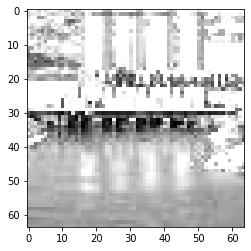

True Value:


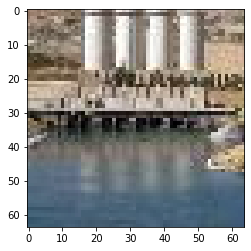

Prediction:


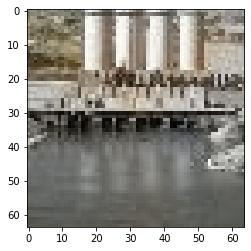

Grayscale image:


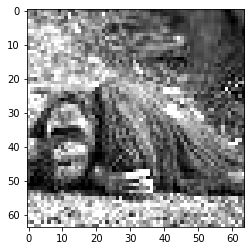

True Value:


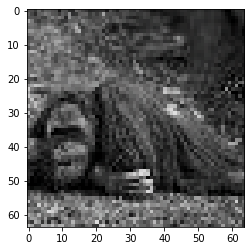

Prediction:


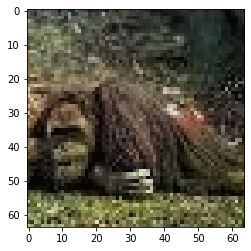

Grayscale image:


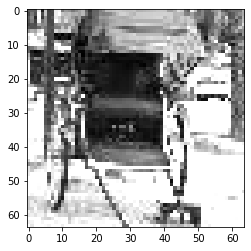

True Value:


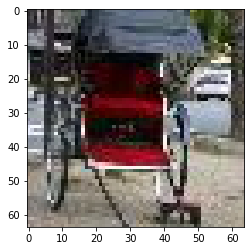

Prediction:


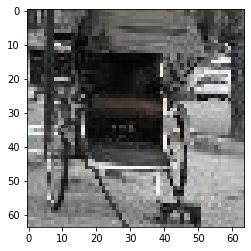

Grayscale image:


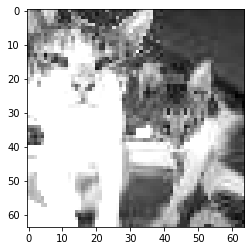

True Value:


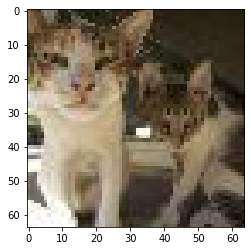

Prediction:


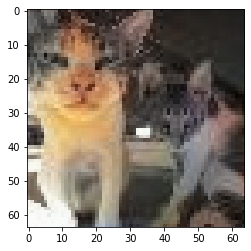

Grayscale image:


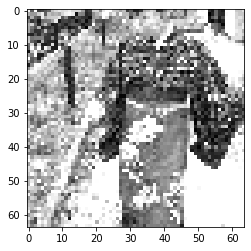

True Value:


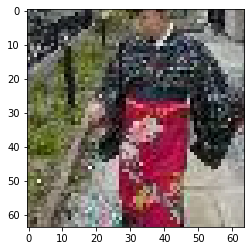

Prediction:


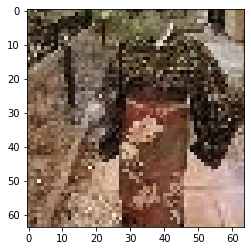

Grayscale image:


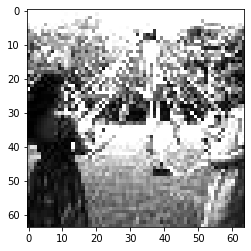

True Value:


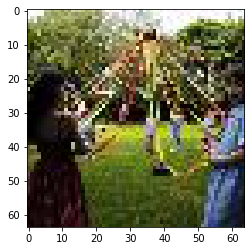

Prediction:


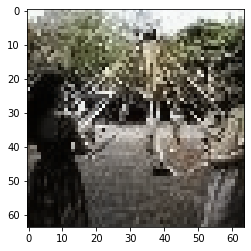

Grayscale image:


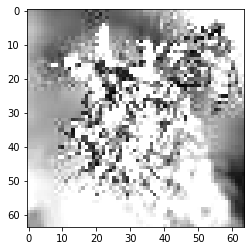

True Value:


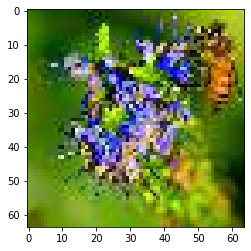

Prediction:


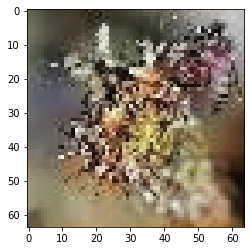

Grayscale image:


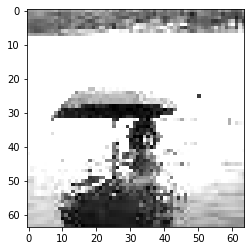

True Value:


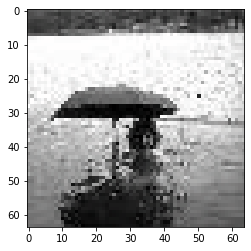

Prediction:


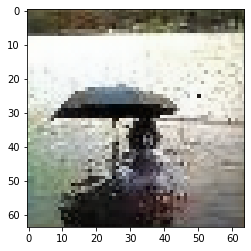

Grayscale image:


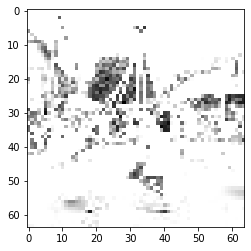

True Value:


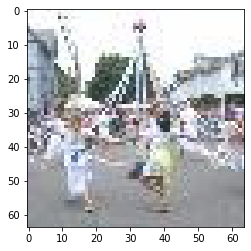

Prediction:


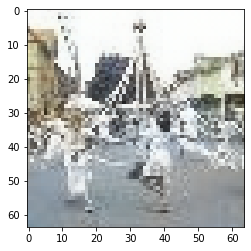

Grayscale image:


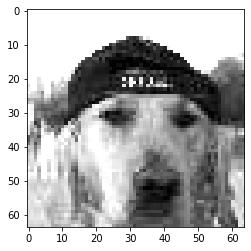

True Value:


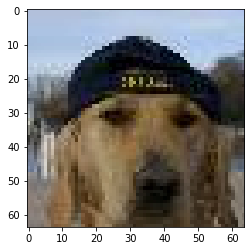

Prediction:


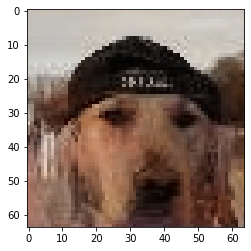

Grayscale image:


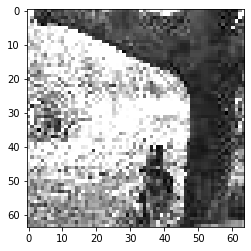

True Value:


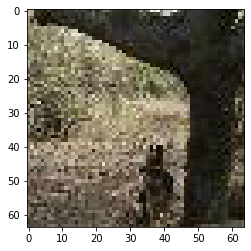

Prediction:


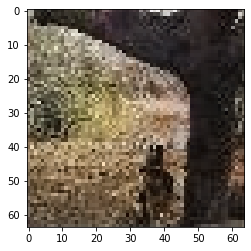

Grayscale image:


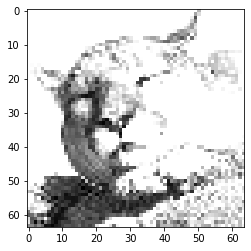

True Value:


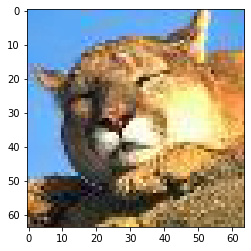

Prediction:


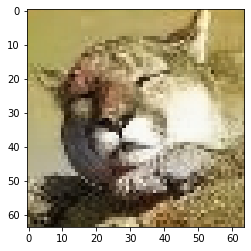

Grayscale image:


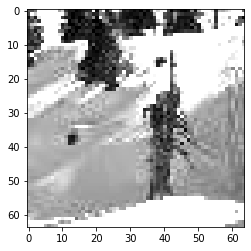

True Value:


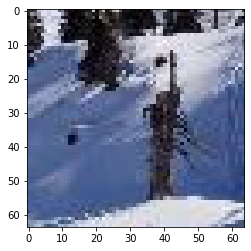

Prediction:


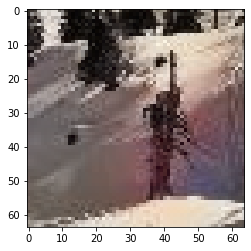

Grayscale image:


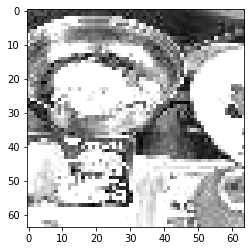

True Value:


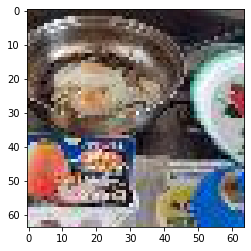

Prediction:


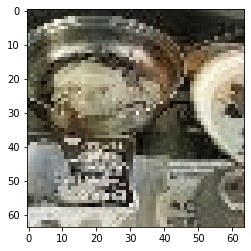

Grayscale image:


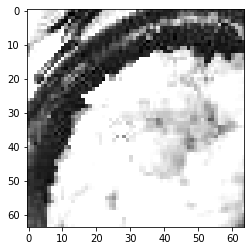

True Value:


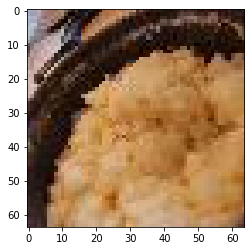

Prediction:


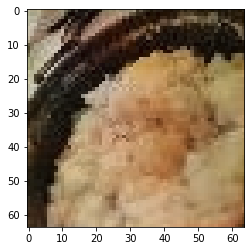

Grayscale image:


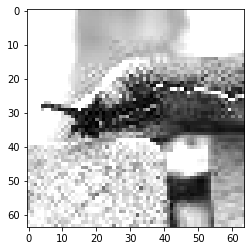

True Value:


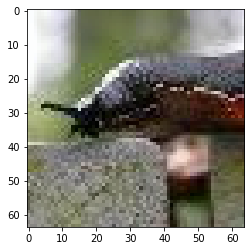

Prediction:


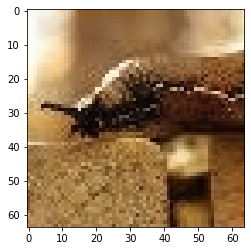

Grayscale image:


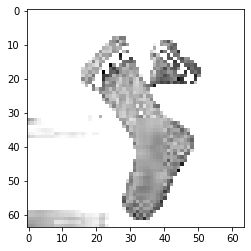

True Value:


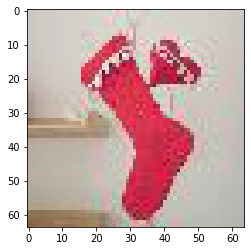

Prediction:


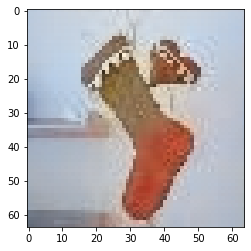

Grayscale image:


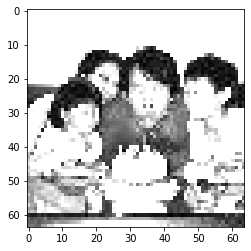

True Value:


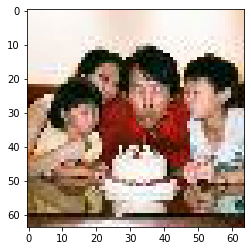

Prediction:


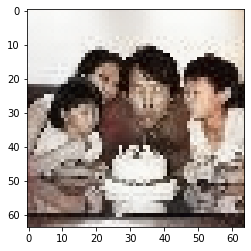

Grayscale image:


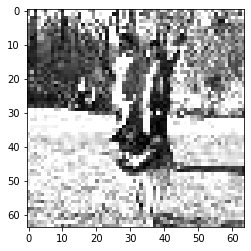

True Value:


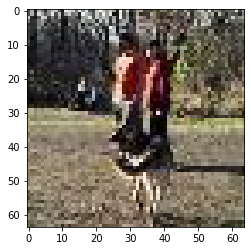

Prediction:


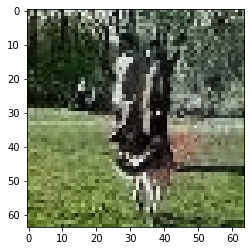

Grayscale image:


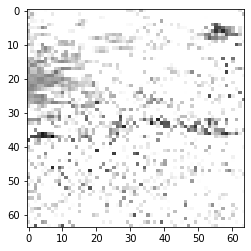

True Value:


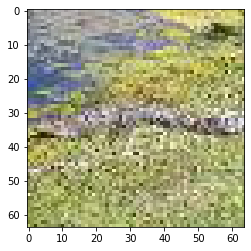

Prediction:


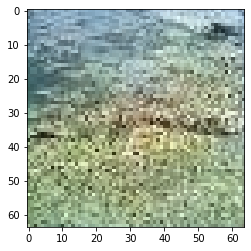

Grayscale image:


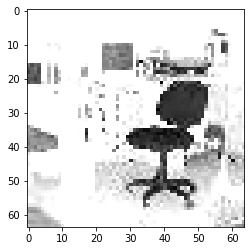

True Value:


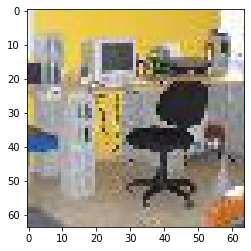

Prediction:


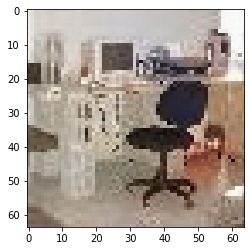

Grayscale image:


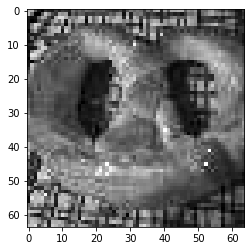

True Value:


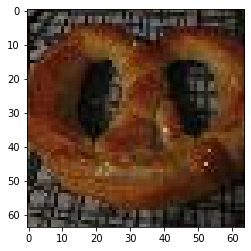

Prediction:


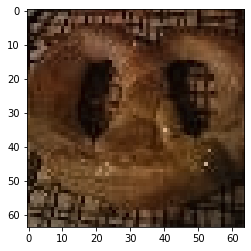

Grayscale image:


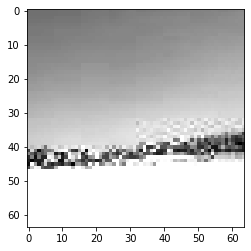

True Value:


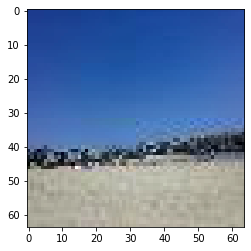

Prediction:


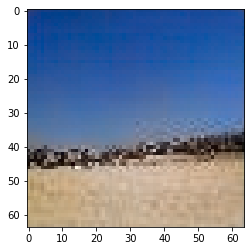

Grayscale image:


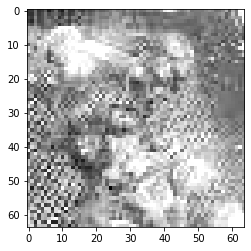

True Value:


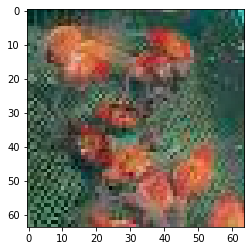

Prediction:


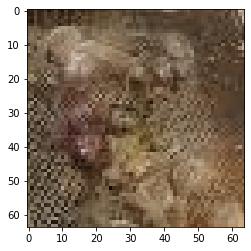

Grayscale image:


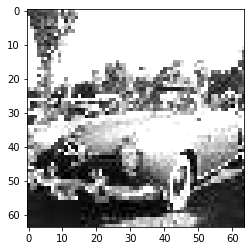

True Value:


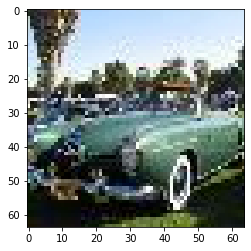

Prediction:


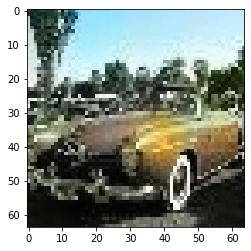

Grayscale image:


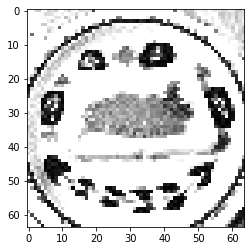

True Value:


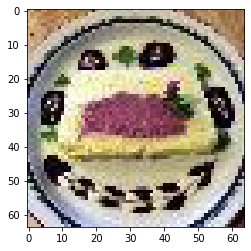

Prediction:


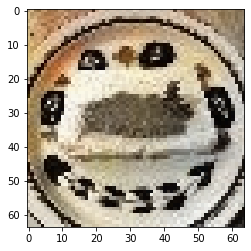

Grayscale image:


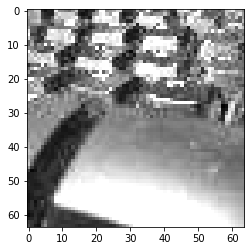

True Value:


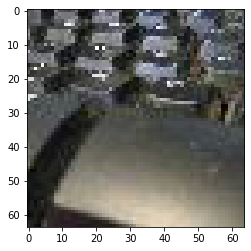

Prediction:


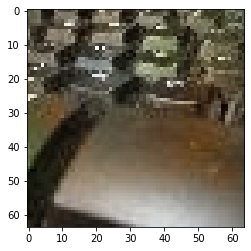

Grayscale image:


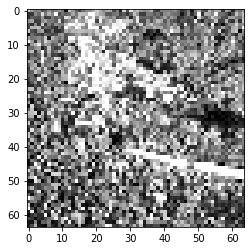

True Value:


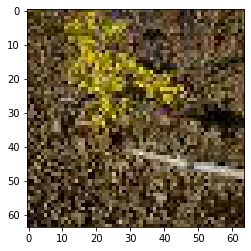

Prediction:


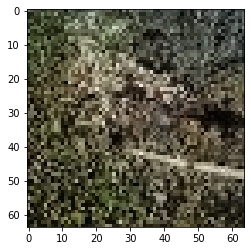

Grayscale image:


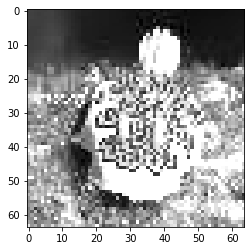

True Value:


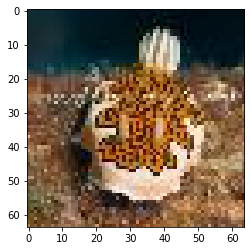

Prediction:


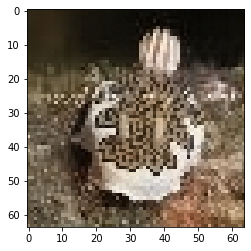

Grayscale image:


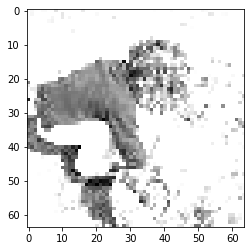

True Value:


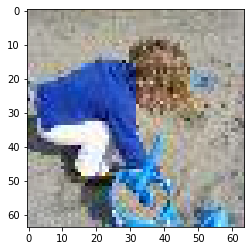

Prediction:


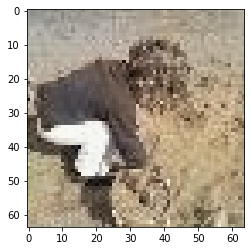

Grayscale image:


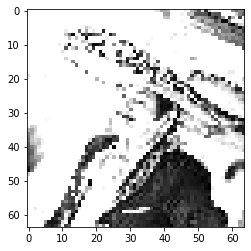

True Value:


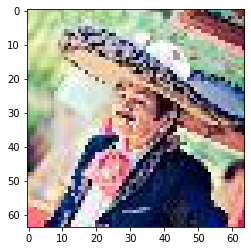

Prediction:


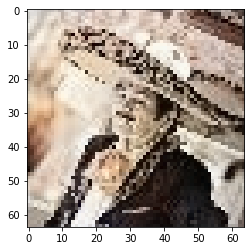

Grayscale image:


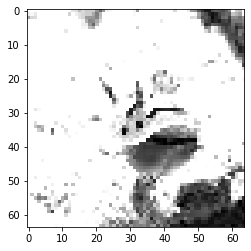

True Value:


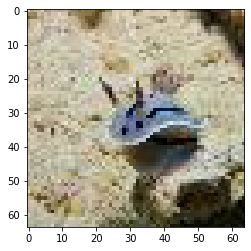

Prediction:


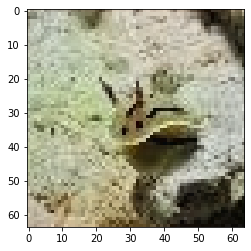

Grayscale image:


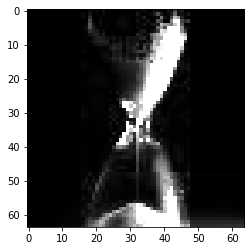

True Value:


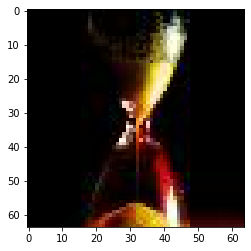

Prediction:


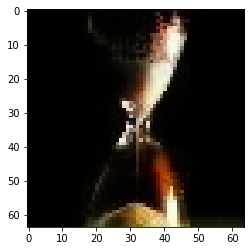

Grayscale image:


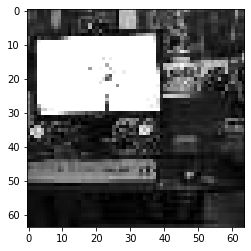

True Value:


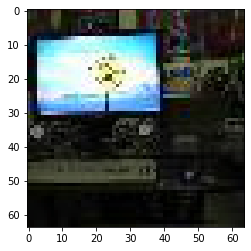

Prediction:


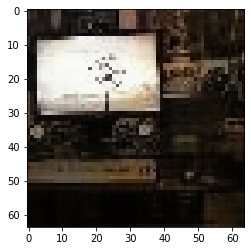

Grayscale image:


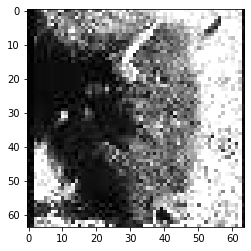

True Value:


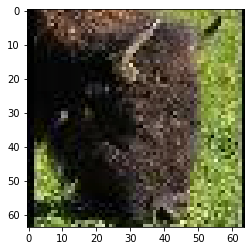

Prediction:


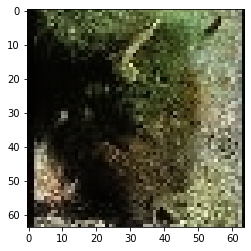

Grayscale image:


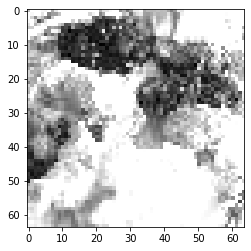

True Value:


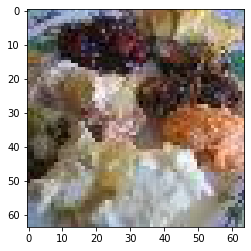

Prediction:


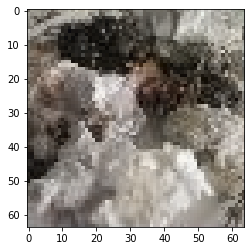

Grayscale image:


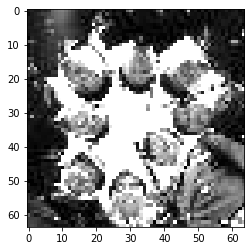

True Value:


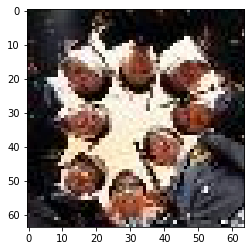

Prediction:


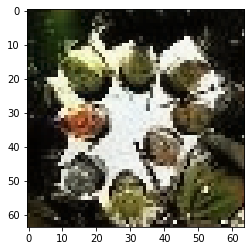

Grayscale image:


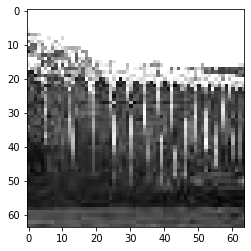

True Value:


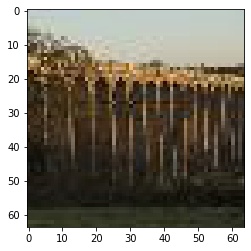

Prediction:


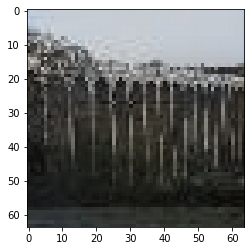

Grayscale image:


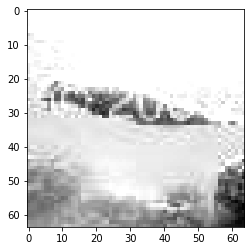

True Value:


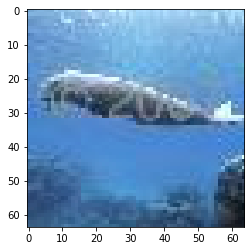

Prediction:


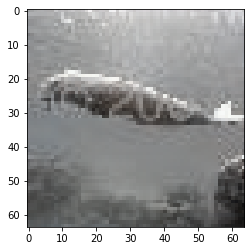

Grayscale image:


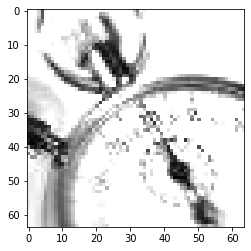

True Value:


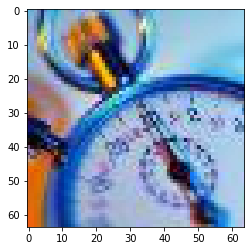

Prediction:


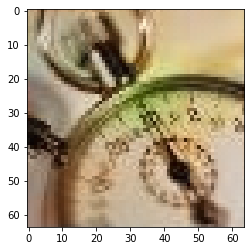

Grayscale image:


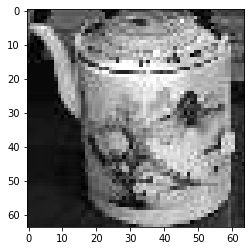

True Value:


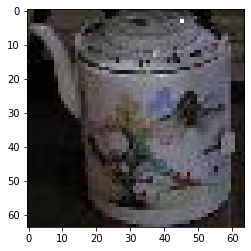

Prediction:


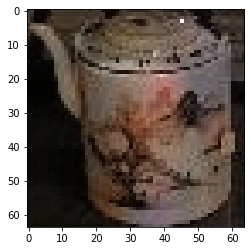

Grayscale image:


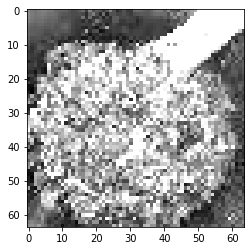

True Value:


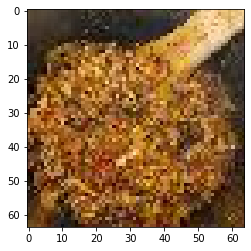

Prediction:


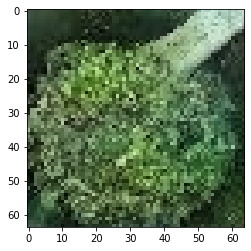

Grayscale image:


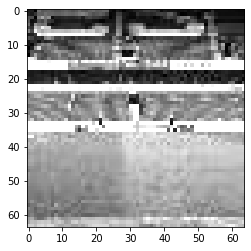

True Value:


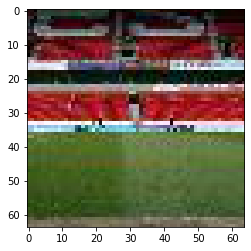

Prediction:


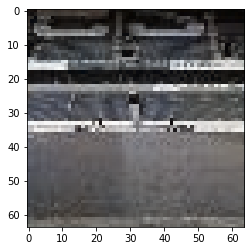

Grayscale image:


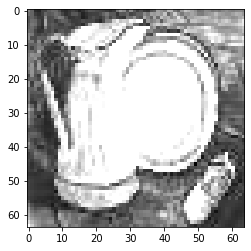

True Value:


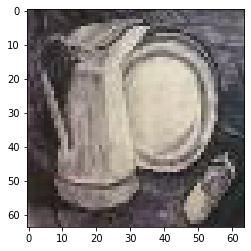

Prediction:


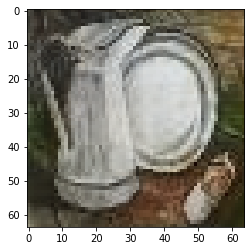

Grayscale image:


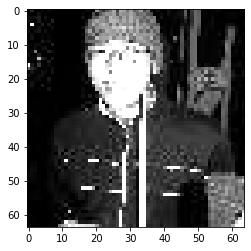

True Value:


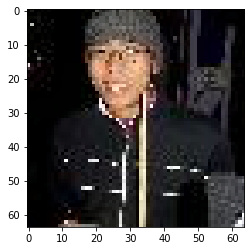

Prediction:


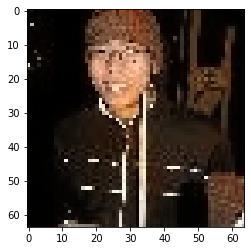

Grayscale image:


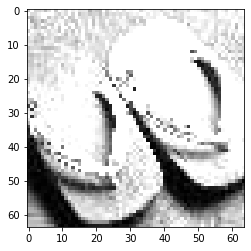

True Value:


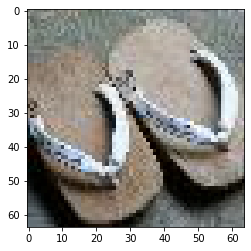

Prediction:


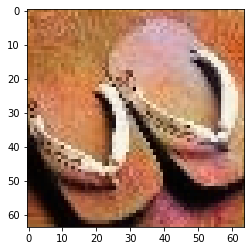

Grayscale image:


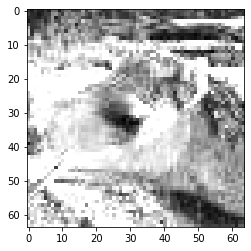

True Value:


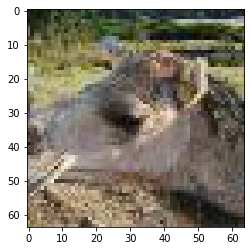

Prediction:


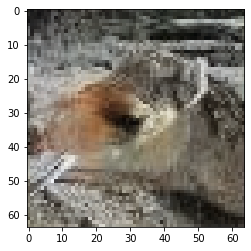

Grayscale image:


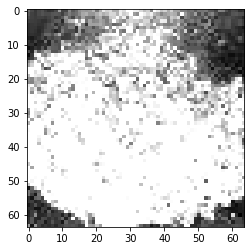

True Value:


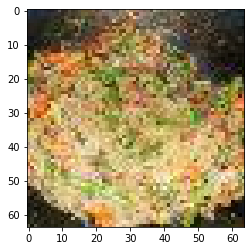

Prediction:


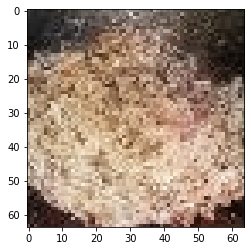

Grayscale image:


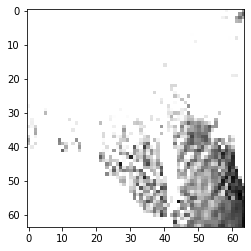

True Value:


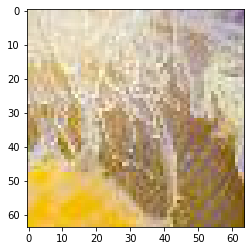

Prediction:


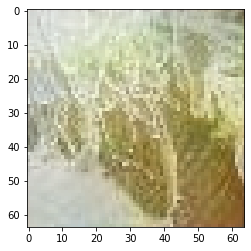

Grayscale image:


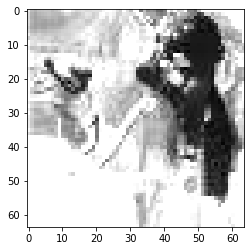

True Value:


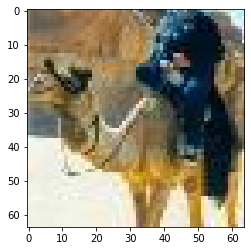

Prediction:


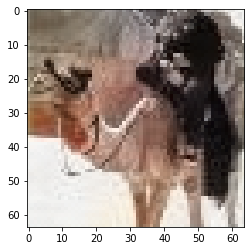

Grayscale image:


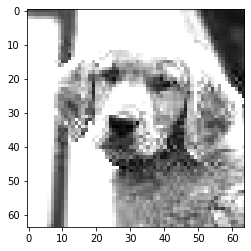

True Value:


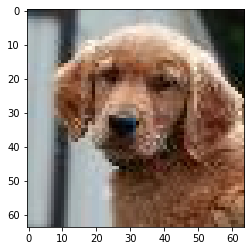

Prediction:


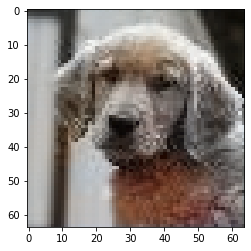

Grayscale image:


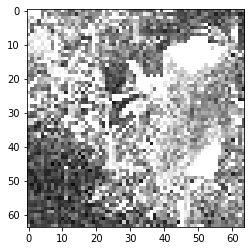

True Value:


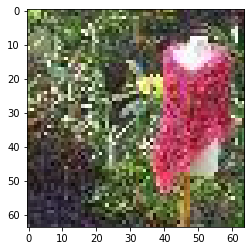

Prediction:


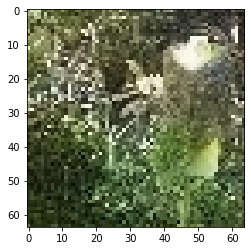

Grayscale image:


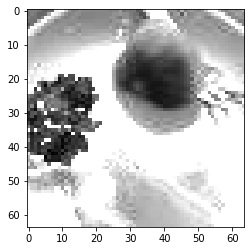

True Value:


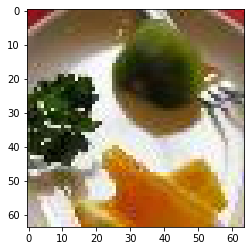

Prediction:


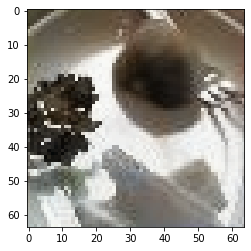

Grayscale image:


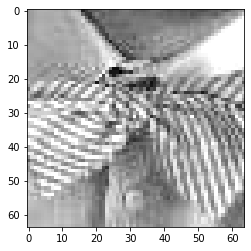

True Value:


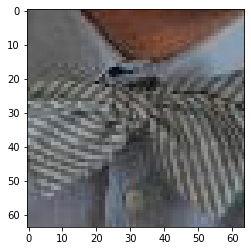

Prediction:


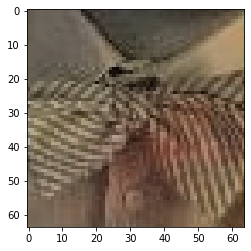

Grayscale image:


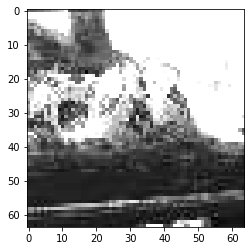

True Value:


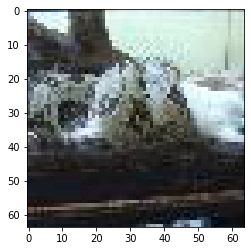

Prediction:


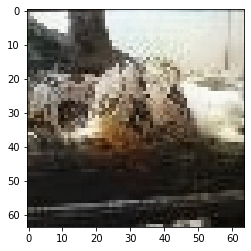

Grayscale image:


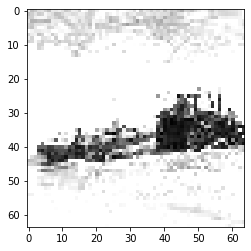

True Value:


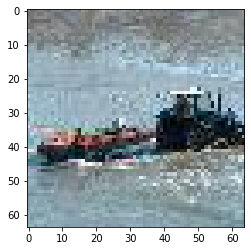

Prediction:


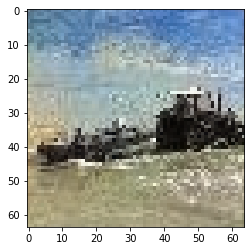

Grayscale image:


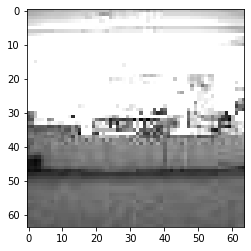

True Value:


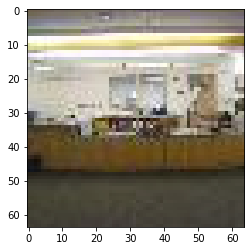

Prediction:


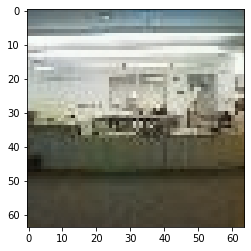

Grayscale image:


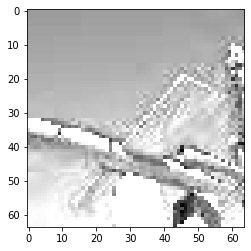

True Value:


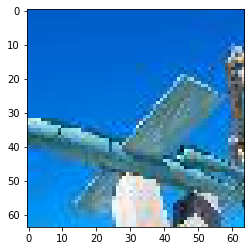

Prediction:


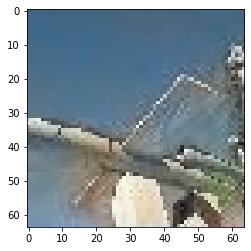

Grayscale image:


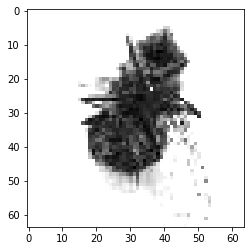

True Value:


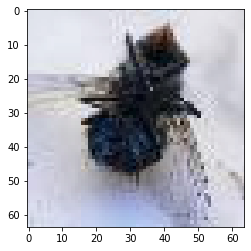

Prediction:


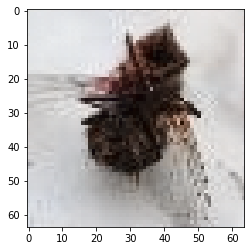

Grayscale image:


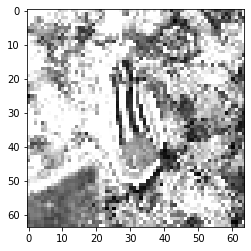

True Value:


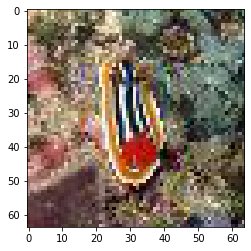

Prediction:


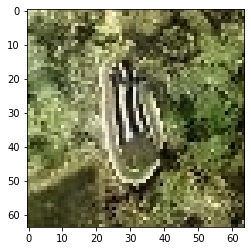

Grayscale image:


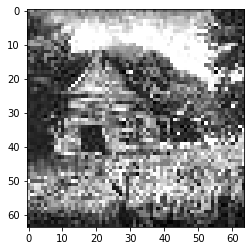

True Value:


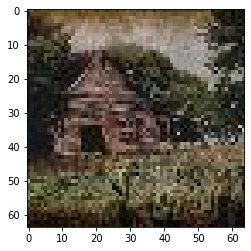

Prediction:


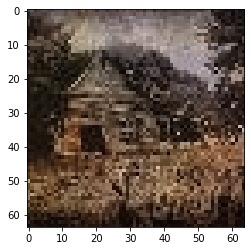

Grayscale image:


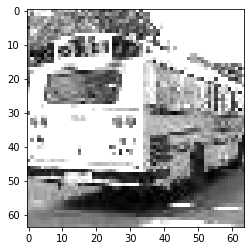

True Value:


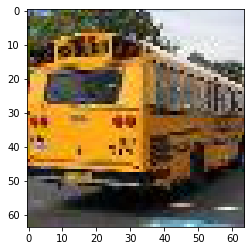

Prediction:


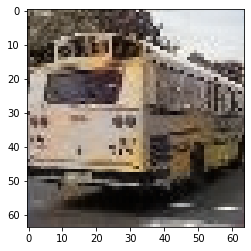

Grayscale image:


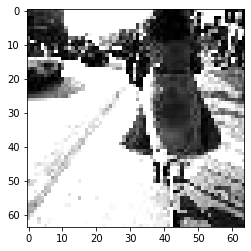

True Value:


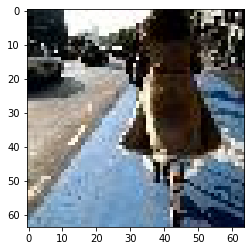

Prediction:


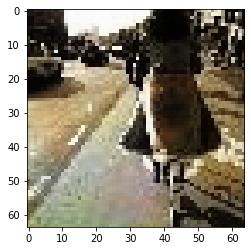

Grayscale image:


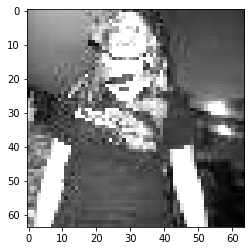

True Value:


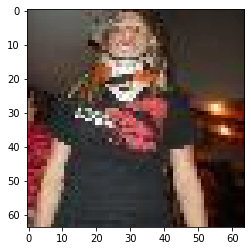

Prediction:


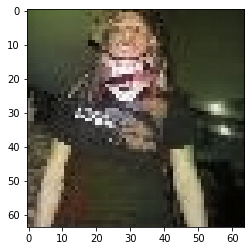

Grayscale image:


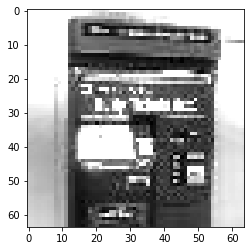

True Value:


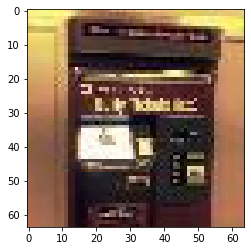

Prediction:


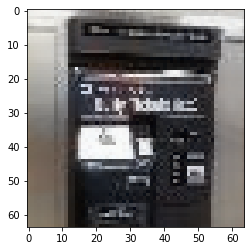

Grayscale image:


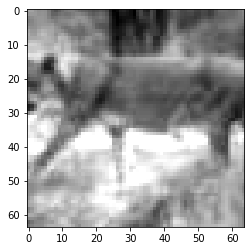

True Value:


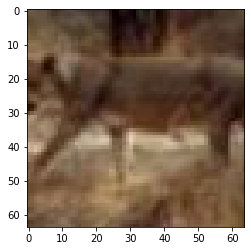

Prediction:


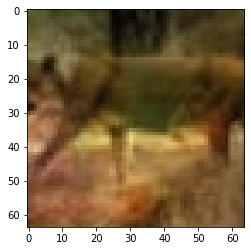

Grayscale image:


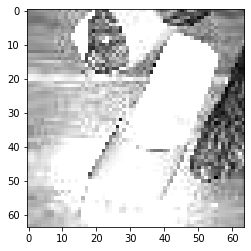

True Value:


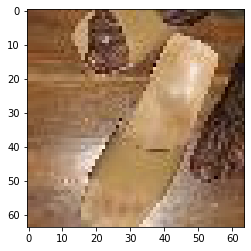

Prediction:


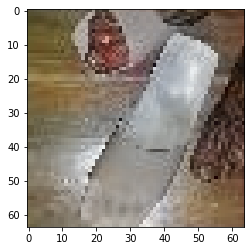

Grayscale image:


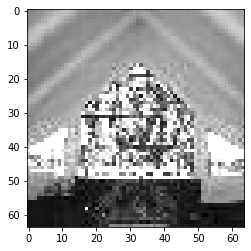

True Value:


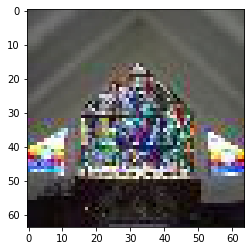

Prediction:


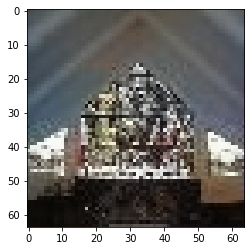

Grayscale image:


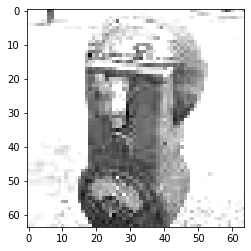

True Value:


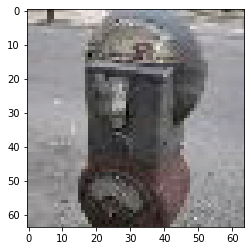

Prediction:


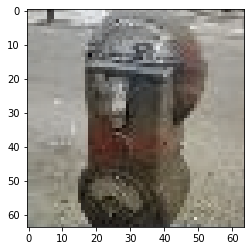

Grayscale image:


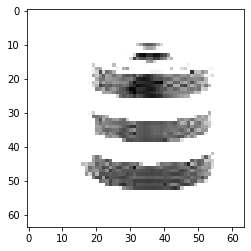

True Value:


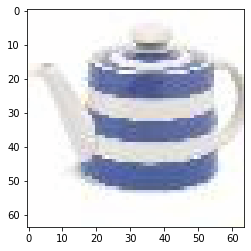

Prediction:


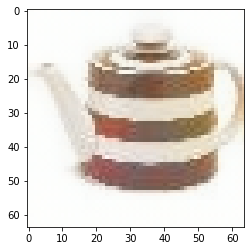

Grayscale image:


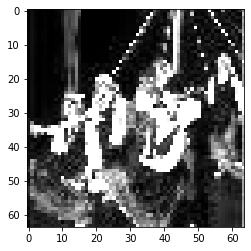

True Value:


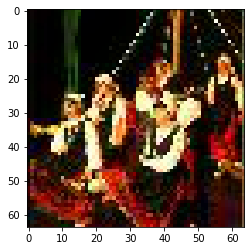

Prediction:


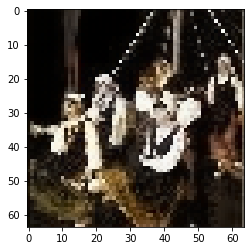

Grayscale image:


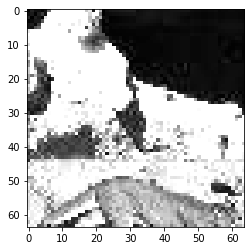

True Value:


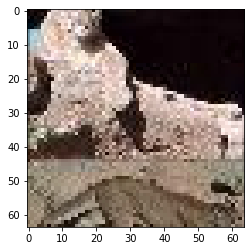

Prediction:


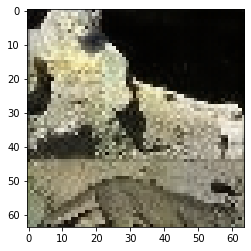

Grayscale image:


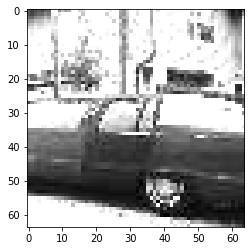

True Value:


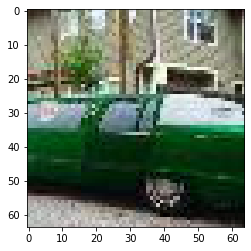

Prediction:


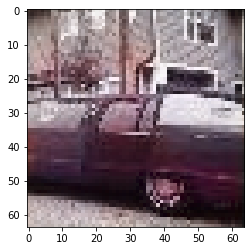

Grayscale image:


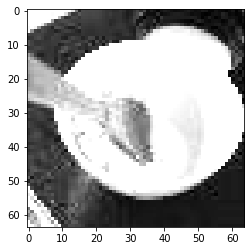

True Value:


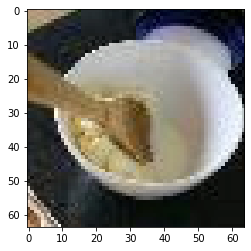

Prediction:


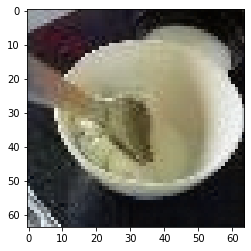

Grayscale image:


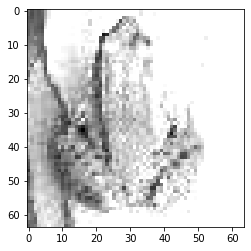

True Value:


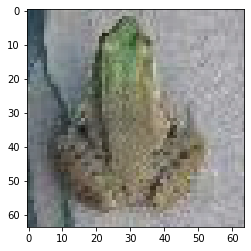

Prediction:


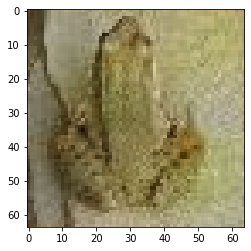

Grayscale image:


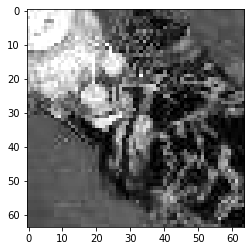

True Value:


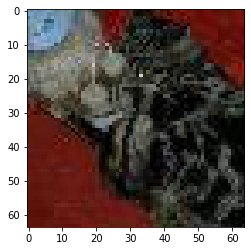

Prediction:


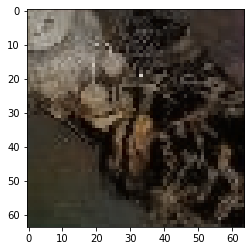

Grayscale image:


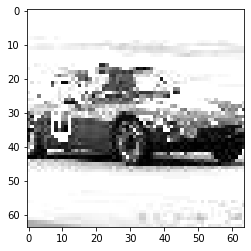

True Value:


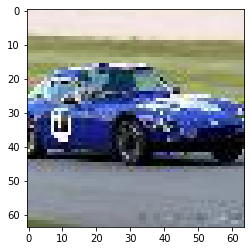

Prediction:


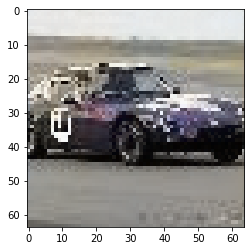

Grayscale image:


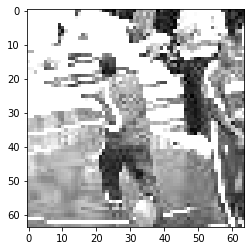

True Value:


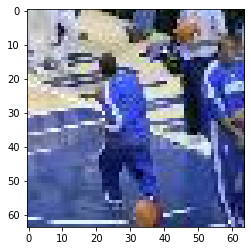

Prediction:


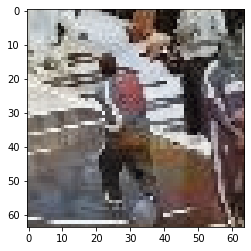

Grayscale image:


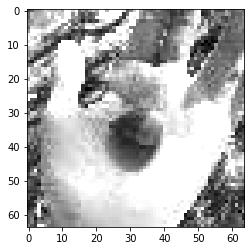

True Value:


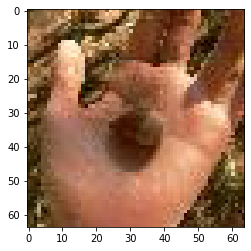

Prediction:


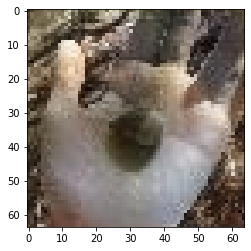

Grayscale image:


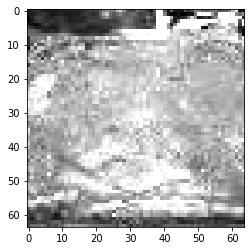

True Value:


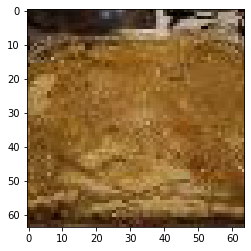

Prediction:


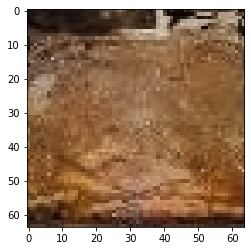

Grayscale image:


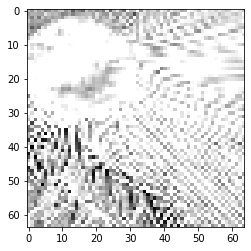

True Value:


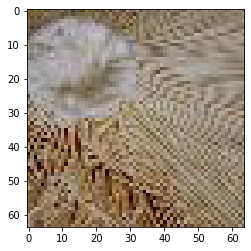

Prediction:


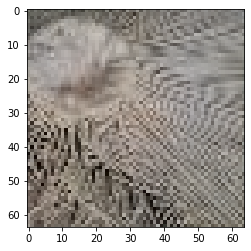

Grayscale image:


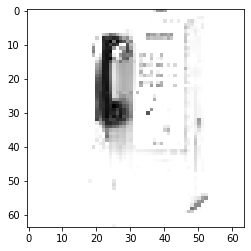

True Value:


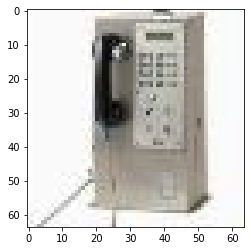

Prediction:


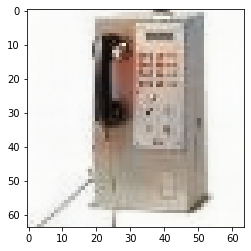

Grayscale image:


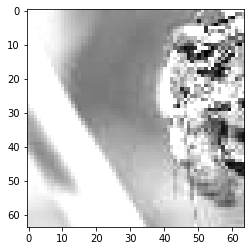

True Value:


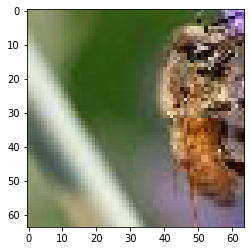

Prediction:


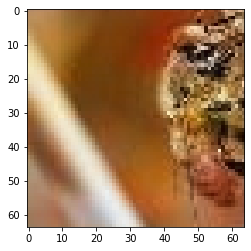

Grayscale image:


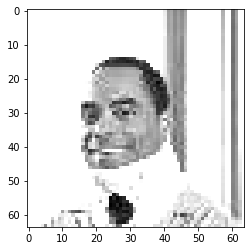

True Value:


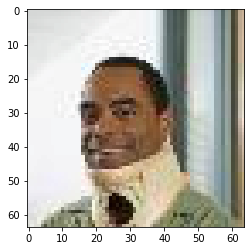

Prediction:


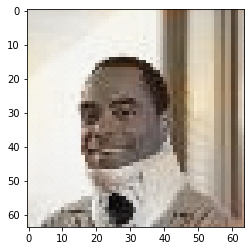

Grayscale image:


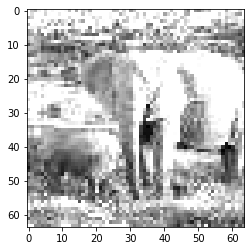

True Value:


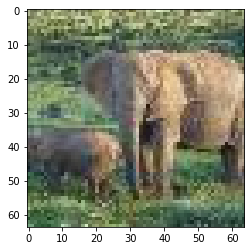

Prediction:


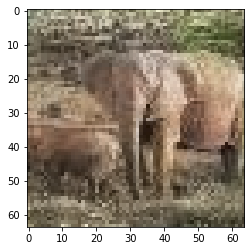

Grayscale image:


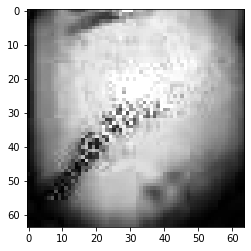

True Value:


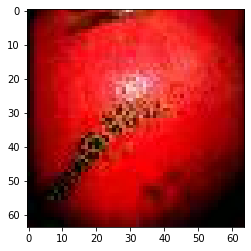

Prediction:


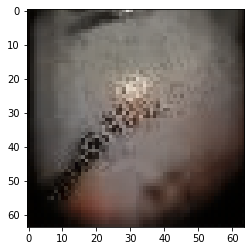

Grayscale image:


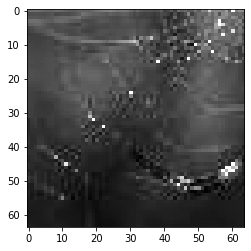

True Value:


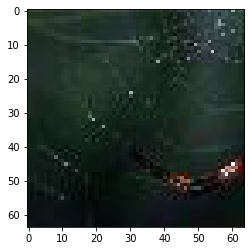

Prediction:


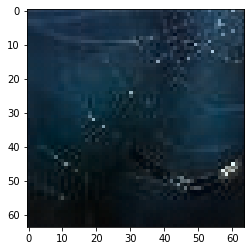

Grayscale image:


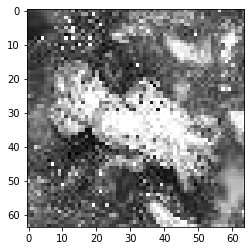

True Value:


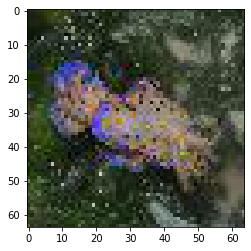

Prediction:


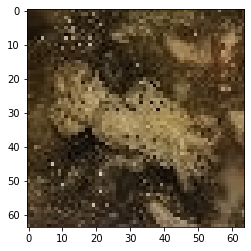

Grayscale image:


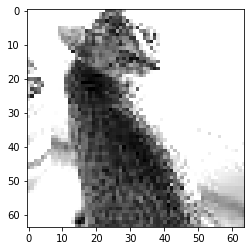

True Value:


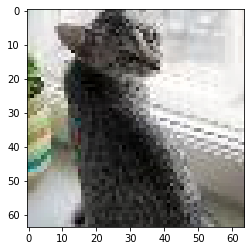

Prediction:


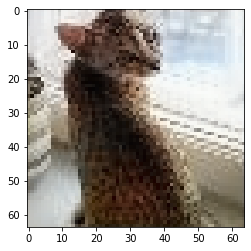

Grayscale image:


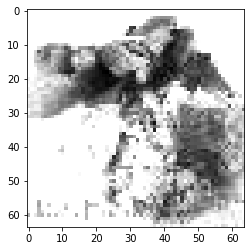

True Value:


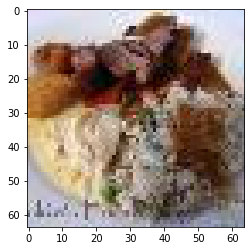

Prediction:


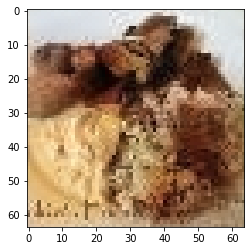

Grayscale image:


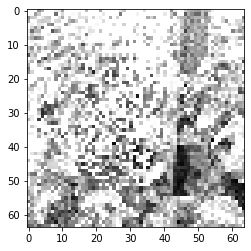

True Value:


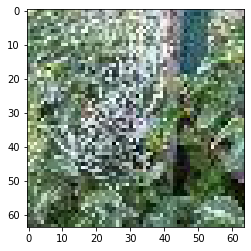

Prediction:


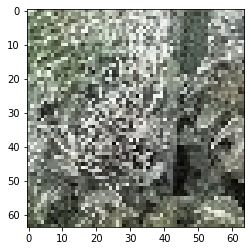

Grayscale image:


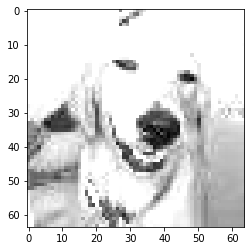

True Value:


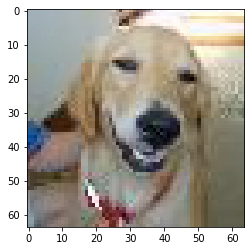

Prediction:


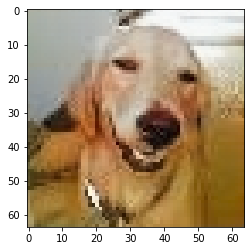

Grayscale image:


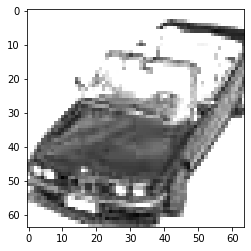

True Value:


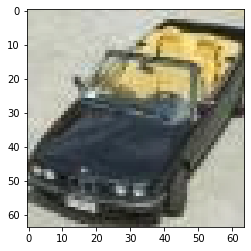

Prediction:


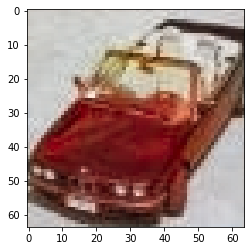

Grayscale image:


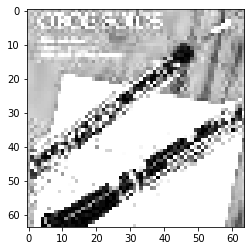

True Value:


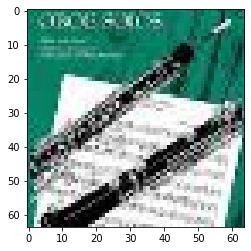

Prediction:


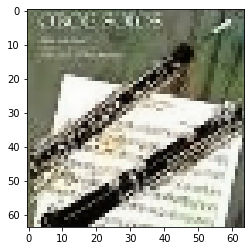

Grayscale image:


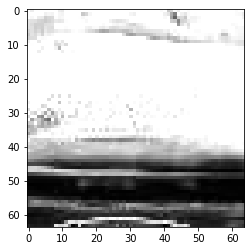

True Value:


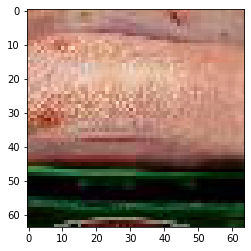

Prediction:


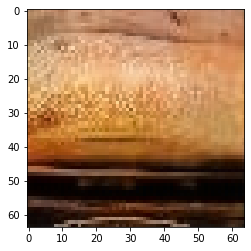

Grayscale image:


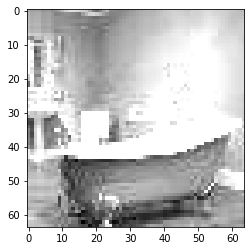

True Value:


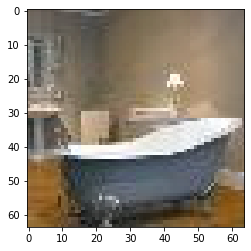

Prediction:


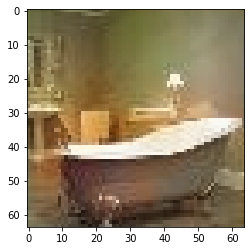

Grayscale image:


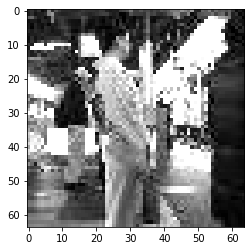

True Value:


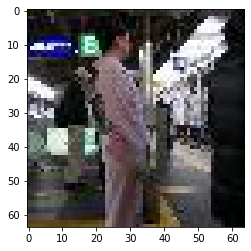

Prediction:


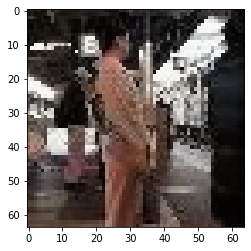

Grayscale image:


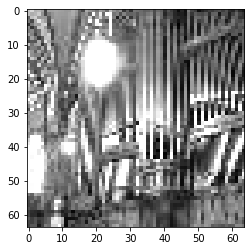

True Value:


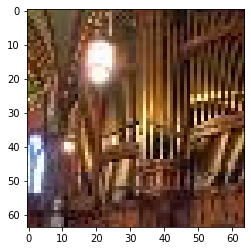

Prediction:


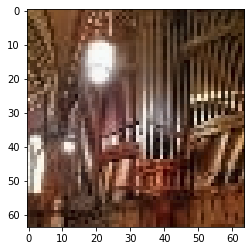

Grayscale image:


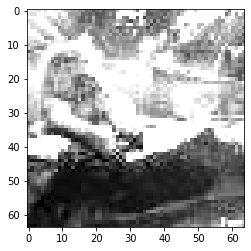

True Value:


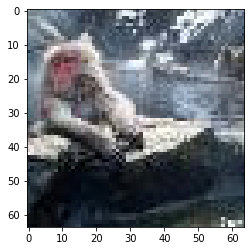

Prediction:


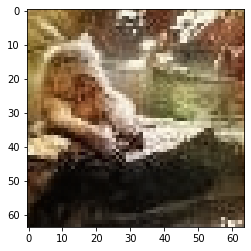

Grayscale image:


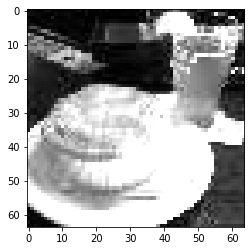

True Value:


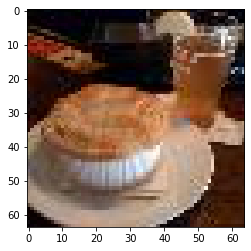

Prediction:


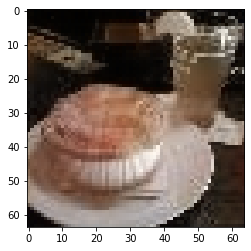

Grayscale image:


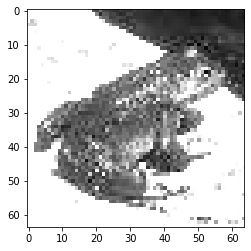

True Value:


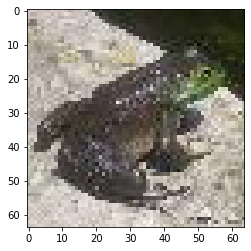

Prediction:


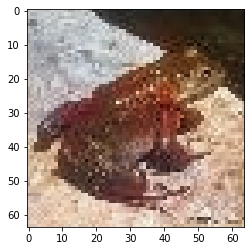

Grayscale image:


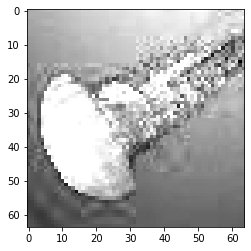

True Value:


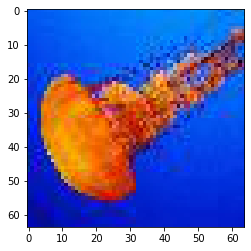

Prediction:


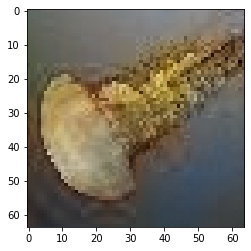

Grayscale image:


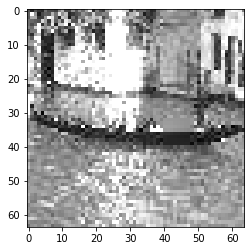

True Value:


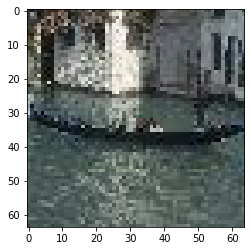

Prediction:


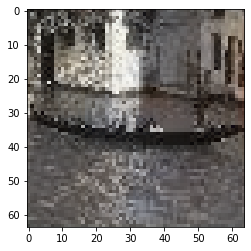

Grayscale image:


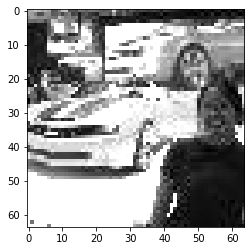

True Value:


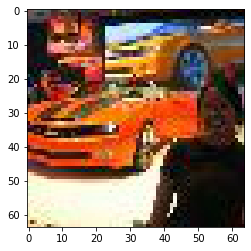

Prediction:


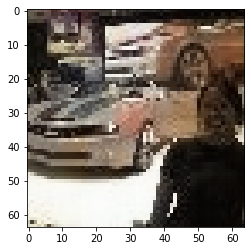

Grayscale image:


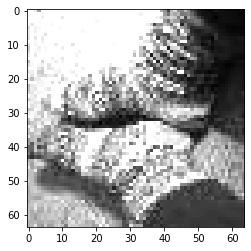

True Value:


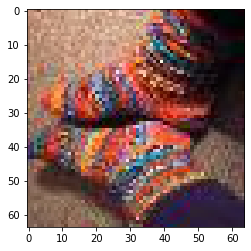

Prediction:


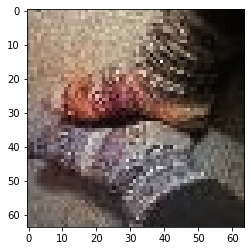

Grayscale image:


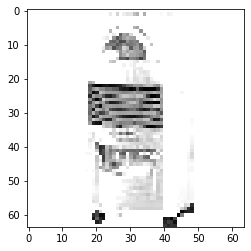

True Value:


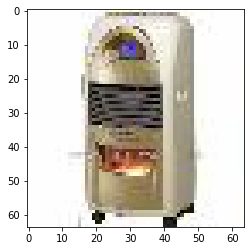

Prediction:


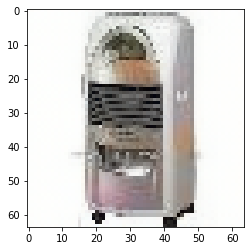

Grayscale image:


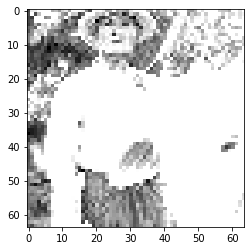

True Value:


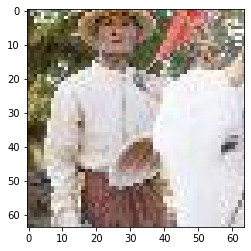

Prediction:


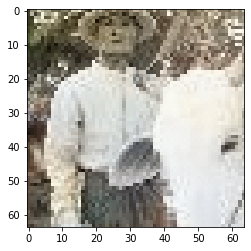

Grayscale image:


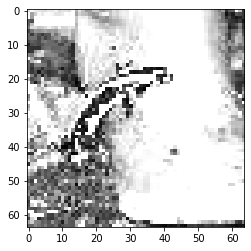

True Value:


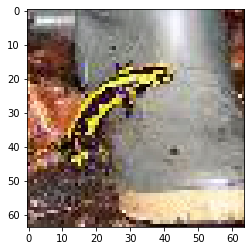

Prediction:


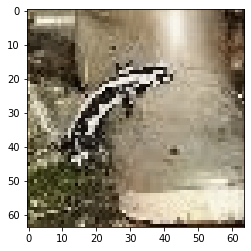

Grayscale image:


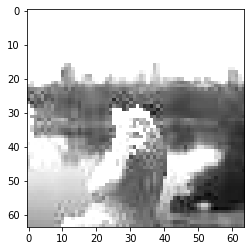

True Value:


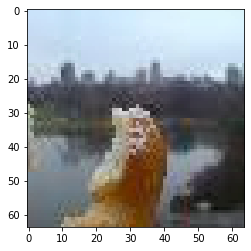

Prediction:


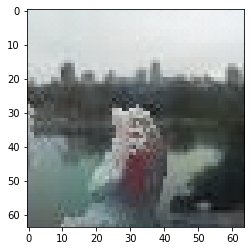

Grayscale image:


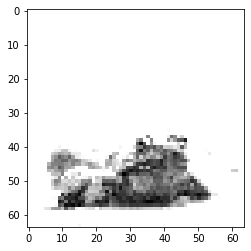

True Value:


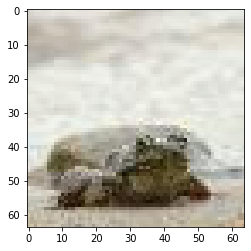

Prediction:


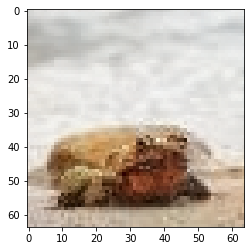

Grayscale image:


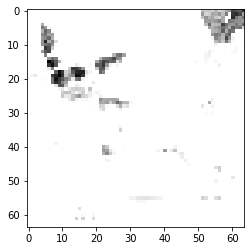

True Value:


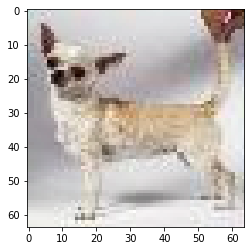

Prediction:


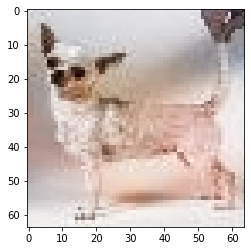

Grayscale image:


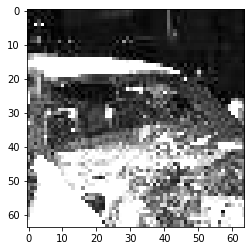

True Value:


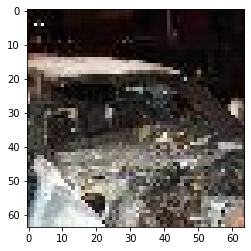

Prediction:


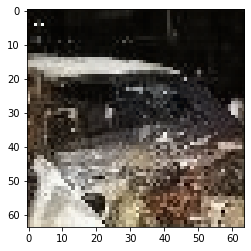

Grayscale image:


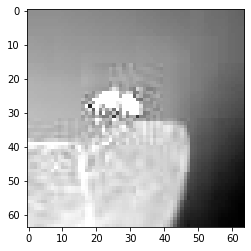

True Value:


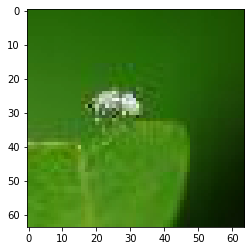

Prediction:


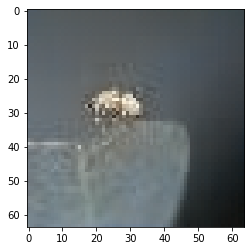

Grayscale image:


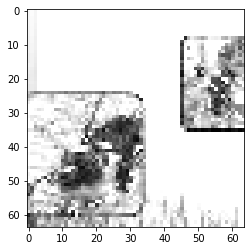

True Value:


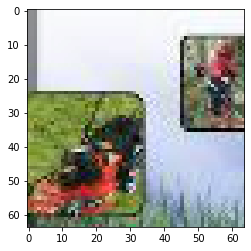

Prediction:


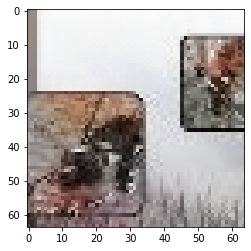

Grayscale image:


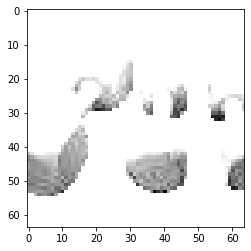

True Value:


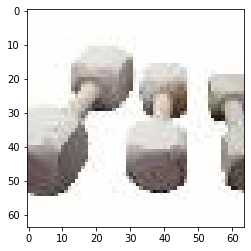

Prediction:


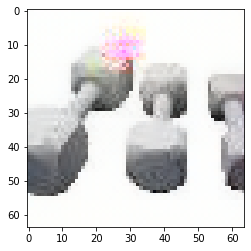

Grayscale image:


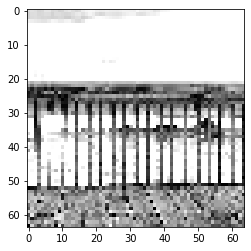

True Value:


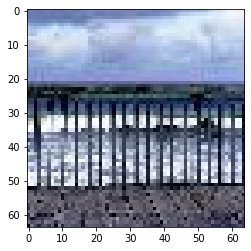

Prediction:


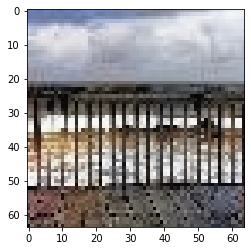

Grayscale image:


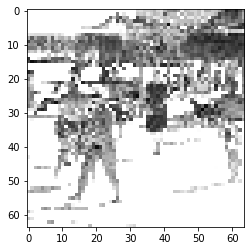

True Value:


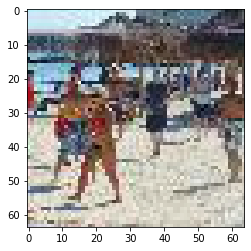

Prediction:


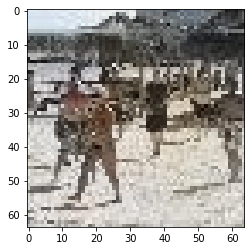

Grayscale image:


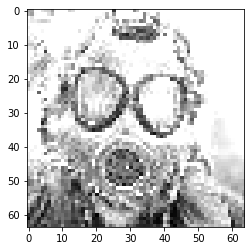

True Value:


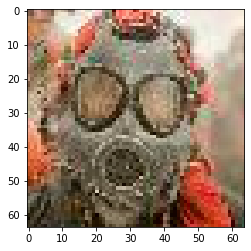

Prediction:


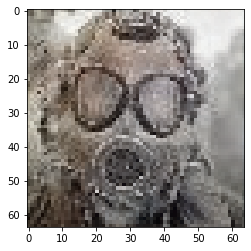

Grayscale image:


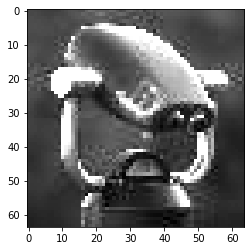

True Value:


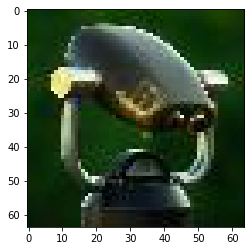

Prediction:


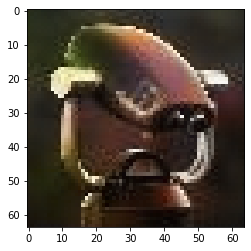

Grayscale image:


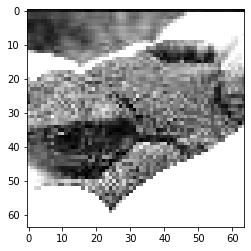

True Value:


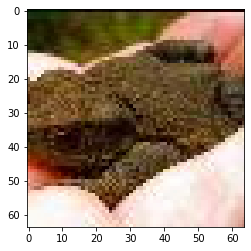

Prediction:


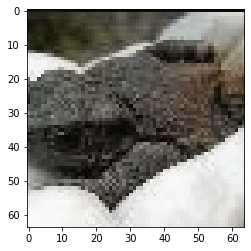

Grayscale image:


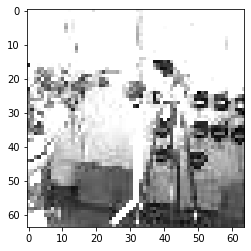

True Value:


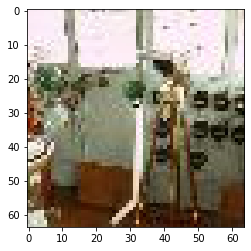

Prediction:


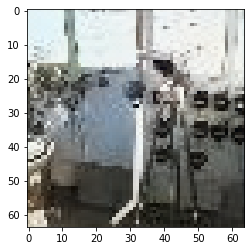

Grayscale image:


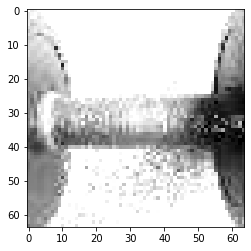

True Value:


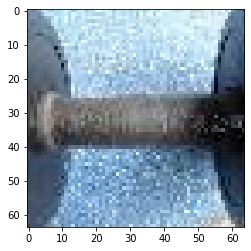

Prediction:


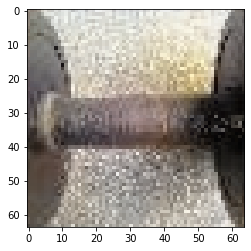

Grayscale image:


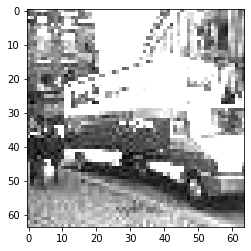

True Value:


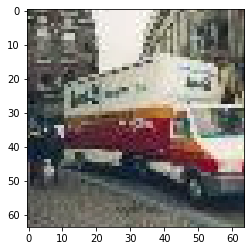

Prediction:


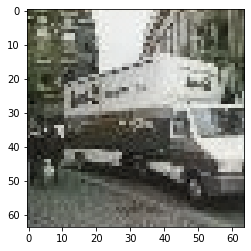

Grayscale image:


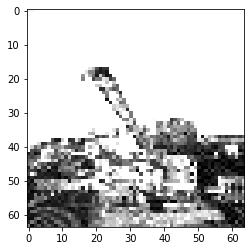

True Value:


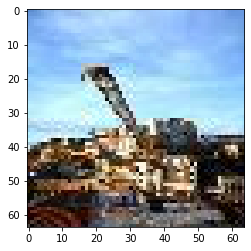

Prediction:


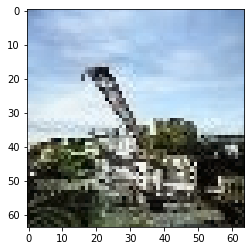

Grayscale image:


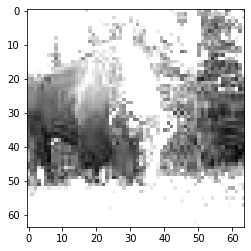

True Value:


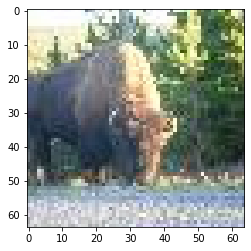

Prediction:


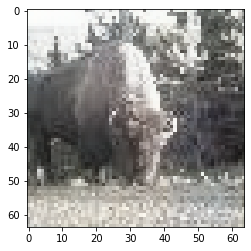

Grayscale image:


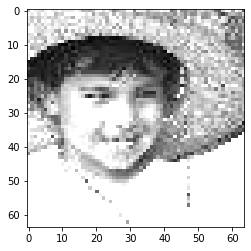

True Value:


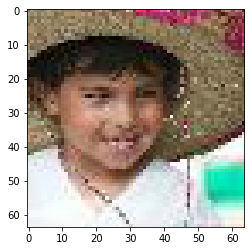

Prediction:


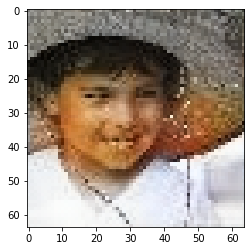

Grayscale image:


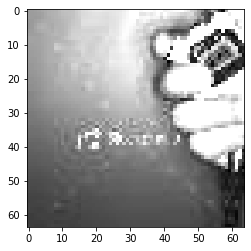

True Value:


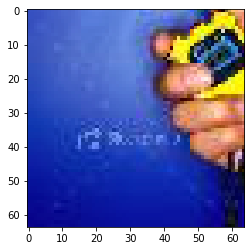

Prediction:


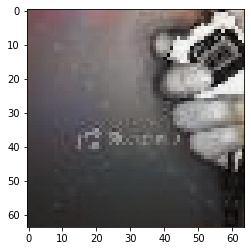

Grayscale image:


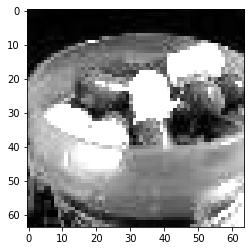

True Value:


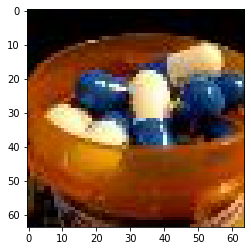

Prediction:


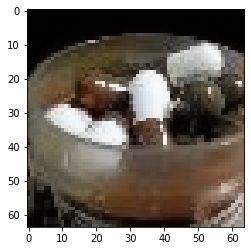

In [ ]:
# results for a batch in rgb space
visualize(x_test, y_test, predictions, 128)

## Improving the model using WGAN

Wasserstein Generative Adversarial Networks (WGANs) are a type of Generative Adversarial Networks (GANs) that use the Wasserstein distance metric to train the generator and discriminator networks; the Wasserstein distance $W$ , is a measure of the amount of work required to transport one probability distribution to another.


$ W(P_r,P_g) = \max_{ ||{f}|| < 1}  \mathbb{E}_{x \sim P_r}[f(x)] - \mathbb{E}_{x \sim P_g} [f(x)]$



In order to achieve such a structure the model has been changed: the discriminator is now called *critic* since the  the last sigmoid function has
been removed. 

### Generator

In [ ]:
Gmodel_W = Generator()
Gmodel_W.cuda()
print(Gmodel_W) 

### Critic 

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, pad):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, 
                      kernel_size=4, stride=stride, padding=pad, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Critic(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):   
        super().__init__()
        self.initial = nn.Sequential(  
                nn.Conv2d(in_channels*2, out_channels=features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []           
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, out_channels=feature, stride=1 if (feature == features[-1] or feature == features[-2]) else 2, pad=0 if (feature == features[-1] or feature == features[-2]) else 1),  #nel paper viene specificato che si usa uno stride=2 eccetto per l'ultimo CNN Block che ha stride = 1 
            )
            in_channels = feature

        layers.append(                                             
            nn.Conv2d(in_channels, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
        )

        self.model = nn.Sequential(*layers)  #qui c'è la creazione del modello a partire dalla lista--> l'asterisco viene usato per dire di prendere tutti i layers

    def forward(self, x, y):        
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [ ]:
Critic = Critic()
Critic.cuda()
print(Critic)

In [ ]:
Test_dis(Critic)

In [ ]:
Critic.cuda()

### Train WGAN


During training, the objective of the discriminator is to maximize the Wasserstein distance between the real and generated data distributions, while the objective of the generator is to minimize this distance.

The main differences between the previous discriminator are the following:
critic architecture is trained 10 times more then the generative architecture, with clipping prameters are added to the weights at each iteration. 

In [ ]:
def train_wg(
    disc, gen, loader, opt_disc, opt_gen, g_scaler, d_scaler,WEIGHT_CLIP,critic_iter
):
    
    loop = tqdm(loader, leave=True)

    for idx, (x, y, z) in enumerate(loop):
        x = x.to("cuda")
        y = y.to("cuda")

        for _ in range(critic_iter):

          #Train the Discriminator
          with torch.cuda.amp.autocast():
            y_fake = gen(x)
            critic_real = disc(x, y)                  
            critic_fake = disc(x, y_fake) 
            loss_critic = - (torch.mean(critic_real) - torch.mean(critic_fake)) 

          disc.zero_grad()
          d_scaler.scale(loss_critic).backward(retain_graph=True)
          d_scaler.step(opt_disc)
          d_scaler.update()

          # clip critic weights between -0.01, 0.01
          for p in disc.parameters():                   
              p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)


        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
          gen_fake = disc(x,y_fake)
          gen_fake_loss = torch.mean(gen_fake)
          loss_gen = -(gen_fake_loss)  
          
        opt_gen.zero_grad()
        g_scaler.scale(loss_gen).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        

        if idx % 100 == 0:
            loop.set_postfix(
                D_real=critic_real.mean().item(),
                D_fake=critic_fake.mean().item(),
                D_loss=loss_critic.mean().item(),
                G_loss=loss_gen.mean().item(),
            )

In [ ]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [ ]:
# Define hyperparameters and settings
LR = 2e-4  # Learning rate   <- da verificare il valore effettivo 
epochs = 10 # Number of epochs
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
LOAD_MODEL = True  
SAVE_MODEL = True
DRIVE = True 

critic_iter = 10     # to add for WGANs, 5 is a typical parameter
weight_clip = 0.01   #to add for WGANs

if DRIVE:
    drive.mount('/content/drive')

# Set loss functions
Doptimizer_W = optim.RMSprop(Critic.parameters(), lr=LR)  #for simple WGANs    
Goptimizer_W = optim.RMSprop(Gmodel_W.parameters(), lr=LR) 

In [ ]:
#to load pretrained models 
if LOAD_MODEL:

  if DRIVE:
    G_CHECKPOINT = "/content/drive/MyDrive/Colab Notebooks/G_CHECKPOINT_WGAN_45"
    D_CHECKPOINT = "/content/drive/MyDrive/Colab Notebooks/D_CHECKPOINT_WGAN_45"
  else:
    files.upload()
    files.upload()
    G_CHECKPOINT = "/content/G_CHECKPOINT_Wgan_L1"
    D_CHECKPOINT = "/content/D_CHECKPOINT_Wgan_L1"

  load_checkpoint(G_CHECKPOINT, Critic, Goptimizer_W, LR)
  load_checkpoint(D_CHECKPOINT, Gmodel_W, Doptimizer_W, LR)


In [ ]:
for epoch in range(epochs):
  print("epoch:",epoch)
  train_wg(
      Critic, Gmodel_W, train_loader, Doptimizer_W, Goptimizer_W, g_scaler, d_scaler, weight_clip, critic_iter
  )
  if SAVE_MODEL:
    if DRIVE:
      save_checkpoint(Gmodel_W, Goptimizer, filename="/content/drive/MyDrive/Colab Notebooks/G_CHECKPOINT_WGAN_55")
      save_checkpoint(Critic, Doptimizer, filename="/content/drive/MyDrive/Colab Notebooks/D_CHECKPOINT_WGAN_55")
    else:
      save_checkpoint(Gmodel_W, Goptimizer, filename="/content/G_CHECKPOINT_L1")
      save_checkpoint(Critic, Doptimizer, filename="/content/D_CHECKPOINT_L1")
      files.download("/content/G_CHECKPOINT_L1") 
      files.download("/content/D_CHECKPOINT_L1")
      

In [ ]:
# test results
x_test, y_test, _ = next(iter(val_loader))
x_test = x_test.cuda()
predictions_W = Gmodel_W(x_test)
predictions_W = predictions_W.cpu()
x_test = x_test.cpu()

In [ ]:
# results in rgb space
visualize(x_test, y_test, predictions_W, 128)